### Table of Contents
* [Libraries](#Libraries)
* [Dataset](#Dataset)
* [Null Values](#Null-Values)
* [Preprocessing](#PreProcessing)
* [1. User Overiew Analysis](#1.-User-Overiew-Analysis)
    * [User Aggregates](#Aggregate-per-user-the-following-information-in-the-column:)
    * [Non-Graphical Univariate Analysis](#Non-Graphical-Univariate-Analysis)
    * [Graphical Univariate Analysis.](#Graphical-Univariate-Analysis.)
    * [Bivariate Analysis](#Bivariate-Analysis)
    * [Variable Transformation](#Variable-transformations)
    * [Correlation Analysis](#Correlation-Analysis)
    * [Dimensionality Reduction](#Dimensionality-Reduction)
* [2. User Engagement Analysis](#2.-User-Engagement-analysis)
    * [Top 10 customers per metric.](#Top-10-users-with-high-sessions-frequency)
    * [Normalization and Kmeans](#Normalize-each-engagement-metric-and-run-a-k-means-(k=3)-to-classify-customers-in-three-groups-of-engagement.)
    * [Most engaged users per app](#*-Aggregate-user-total-traffic-per-application-and-derive-the-top-10-most-engaged-users-per-application)
    * [Most used apps](#*-Plot-the-top-3-most-used-applications.)
    * [KMeans](#*-Using-k-means-clustering-algorithm,-group-users-in-k-engagement-clusters-based-on-the-engagement-metrics:)
* [3. User Experience Analysis](#3.-Experience-Analytics)
    * [Top 10, Bottom 10 and Frequent 10](#Compute-&-list-10-of-the-top,-bottom-and-most-frequent:)
    * [Throughput Distribution and Average TCP](#Compute-&-report:)
    * [KMeans](#Using-the-experience-metrics-above,-perform-a-k-means-clustering-(where-k-=-3)-to-segment-users-into-groups-of-experiences-and-provide-a-brief-description-of-each-cluster.)
* [4. User Satisfaction Analysis](#1.-User-Overiew-Analysis)
    * [Engagement and Experience scores](#Write-a-python-program-to-assign:)
    * [Satisfaction Score](#Merge-the-engagement-and-experience-datasets)
    * [Regression Model.](#Run-a-regression-model-of-your-choice-to-predict-the-satisfaction-score-of-a-customer.)
    * [Kmeans](#Run-a-k-means-(k=2)-on-the-engagement-&-the-experience-score.)
    * [Cluster Scores](#Aggregate-the-average-engagement-&-experience-score-per-cluster.)
    * [Correlation Analysis](#Correlation-Analysis)
    * [MySQL](#Export-your-final-table-containing-all-user-id-+-engagement,-experience-&-satisfaction-scores-in-your-local-MySQL-database.-Report-a-screenshot-of-a-select-on-the-exported-table.)

## Libraries

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.cluster import KMeans
import scipy.spatial.distance as dist
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


import warnings
warnings.filterwarnings(action="ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Week2_challenge_data_source.xlsx


## Dataset

In [391]:
raw = pd.read_excel('/kaggle/input/Week2_challenge_data_source.xlsx')
raw.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [392]:
raw.shape

(150001, 55)

Quite a bulk dataset.

## PreProcessing

### Numerical, Categorical and TimeStamp features

In [393]:
numerical = []
categorical = []
timestamps = []

for col in raw.columns:
    if raw[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical.append(col)
    elif raw[col].dtype == object:
        categorical.append(col)
    else:
        timestamps.append(col)
        
        
features = numerical+categorical+timestamps
data = raw[features]
data.head(3)

,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),...,Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Bearer Id,Last Location Name,Handset Manufacturer,Handset Type,Start,End
0,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.0,5.0,23.0,44.0,...,171744450.0,8814393.0,36749741.0,308879636.0,13114483460844900352,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F,2019-04-04 12:01:18,2019-04-25 14:35:31
1,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.0,5.0,16.0,26.0,...,526904238.0,15055145.0,53800391.0,653384965.0,13114483482878900224,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530),2019-04-09 13:04:04,2019-04-25 08:15:48
2,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,NaN,NaN,6.0,9.0,...,410692588.0,4215763.0,27883638.0,279807335.0,13114483484080500736,D42335A,Samsung,Samsung Galaxy A8 (2018),2019-04-09 17:42:11,2019-04-25 11:58:13


In [394]:
data.dtypes

Start ms                                           float64
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float64
50 Kbps < DL TP < 250 Kbps (%)                     float64
250 Kbps < DL TP < 1 Mbps (%)                      float64
DL TP > 1 Mbps (%)                                 float64
UL TP < 10 Kbps (%)                                float

In [395]:
data.shape

(150001, 55)

### Null Values

#### Numerical Cols

In [396]:
#Null numerical values (percentage)
null = data[numerical].isna().sum().sort_values(ascending = False)
null_per = (null/150001) * 100
null_perc = pd.DataFrame(null_per)
null_perc

,0
Nb of sec with 37500B < Vol UL,86.835421
Nb of sec with 6250B < Vol UL < 37500B,74.561503
Nb of sec with 125000B < Vol DL,65.024900
TCP UL Retrans. Vol (Bytes),64.432237
Nb of sec with 31250B < Vol DL < 125000B,62.390251
Nb of sec with 1250B < Vol UL < 6250B,61.928920
Nb of sec with 6250B < Vol DL < 31250B,58.877607
TCP DL Retrans. Vol (Bytes),58.763608
HTTP UL (Bytes),54.539636
HTTP DL (Bytes),54.315638


Some columns have big percentages of missing values. For the meantime, imputation with column means will be done incase the columns come in handy. Otherwise, they'll be dropped. The **big_data** list below will store the names of cols with missing values > 50%

In [397]:
# columns with >50% null values
bad_data = []
for entry, column in zip(null_perc.iloc[:, 0], null_perc.index):
    if entry >= 50:
        bad_data.append(column)
        
# bad_data

All the numerical columns with missing values will be imputed with the mean of the column given the absence of nominal columns.

In [398]:
# get the numerical null values indices from the dataframe
a = null_perc.index.to_list()
# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
# col_index
len(indices)

49

In [399]:
# MSISDN/Number is more of a categorical column than numurical given its a unique id for each user.
# imputing it with mean would result to the creation of non-existence users. Like other categorical variables with nan, it'll be imputed with mode
data.columns.get_loc('MSISDN/Number')

4

In [400]:
indices.remove(4)
len(indices)

48

In [401]:
#imputing with column means.
columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x    

In [402]:
data[numerical].isna().any()

Start ms                                    False
End ms                                      False
Dur. (ms)                                   False
IMSI                                        False
MSISDN/Number                                True
IMEI                                        False
Avg RTT DL (ms)                             False
Avg RTT UL (ms)                             False
Avg Bearer TP DL (kbps)                     False
Avg Bearer TP UL (kbps)                     False
TCP DL Retrans. Vol (Bytes)                 False
TCP UL Retrans. Vol (Bytes)                 False
DL TP < 50 Kbps (%)                         False
50 Kbps < DL TP < 250 Kbps (%)              False
250 Kbps < DL TP < 1 Mbps (%)               False
DL TP > 1 Mbps (%)                          False
UL TP < 10 Kbps (%)                         False
10 Kbps < UL TP < 50 Kbps (%)               False
50 Kbps < UL TP < 300 Kbps (%)              False
UL TP > 300 Kbps (%)                        False


#### Categorical and Timestamp cols

In [403]:
#Null categorical and timestamps values 
null = data[categorical + timestamps].isna().sum().sort_values(ascending = False)
null = (null/150001) * 100
null = pd.DataFrame(null)
null

,0
Last Location Name,0.768662
Handset Type,0.381331
Handset Manufacturer,0.381331
End,0.000667
Start,0.000667
Bearer Id,0.000000


The null values in these columns contribute a small percentage to the column values, thus not  a big deal. Imputation will be done using the mode/most_frequent value. But first, they have to be converted to type **str**.

In [404]:
for col in categorical+timestamps:
    data[col] = data[col].astype(str)

In [405]:
# get the numerical null values indices from the dataframe
a = null.index.to_list()
# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
    
indices

[50, 52, 51, 54, 53, 49]

In [406]:
# imputing with mode
indices.append(4) #the user id col
columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x   

In [407]:
data[categorical+timestamps].isna().any()

Bearer Id               False
Last Location Name      False
Handset Manufacturer    False
Handset Type            False
Start                   False
End                     False
dtype: bool

All null values taken care of.

### Timestamps to Pandas Datetime object
For imputation to work, their data type had to be change to string. That has to be reversed.

In [408]:
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

### Feature Generation

In [409]:
data['total_bytes'] =  data['Total UL (Bytes)'] + data['Total DL (Bytes)']
data['social_media'] = data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)']
data['email'] = data['Email DL (Bytes)'] + data['Email UL (Bytes)']
data['google'] = data['Google DL (Bytes)'] + data['Google UL (Bytes)']
data['youtube'] = data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)']
data['netflix'] = data['Netflix UL (Bytes)'] + data['Netflix DL (Bytes)']
data['gaming'] = data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)']
data['other'] = data['Other DL (Bytes)'] + data['Other UL (Bytes)']
data['total_tp'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
data['total_rtt'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
data['total_tcp'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']

### Encoding Categorical columns

The method pd.get_dummies() encodes categorical variables using the OneHotEncoder method which is preferred over the LabelEncoder. The latter assigns numerical valuesm to the variable's values hierarchically. This will result to biased data since some entries could be perceived as having more weight than others when the only difference is class type.
Despite the preference of OHE  over LE, the dataset is already big, encoding it with OHE would increase it's size at least twice. Due to computational limitations (memory allocation), LE is used. But always, OHE is a better performer.

In [410]:
# enc_data = pd.get_dummies(data).reset_index(drop=True)
# enc_data.shape
data[categorical].head(3)

,Bearer Id,Last Location Name,Handset Manufacturer,Handset Type
0,13114483460844900352,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F
1,13114483482878900224,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530)
2,13114483484080500736,D42335A,Samsung,Samsung Galaxy A8 (2018)


In [411]:
columns = [50, 52, 51, 49]
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    encoder = LabelEncoder()
    encoder = encoder.fit(x)
    x = encoder.transform(x)
    name = data.columns[col]
    data[name + '_encoded'] = x   # create new columns with the encoded values instead of replacing them, might come in handy at later stages

## 1. User Overiew Analysis

### Top 10 handsets

In [412]:
top_10_sets = data['Handset Type'].value_counts(ascending = False).head(10)
top_10_sets = pd.DataFrame(top_10_sets)
top_10_sets

,Handset Type
Huawei B528S-23A,19752
Apple iPhone 6S (A1688),9419
Apple iPhone 6 (A1586),9023
undefined,8987
Apple iPhone 7 (A1778),6326
Apple iPhone Se (A1723),5187
Apple iPhone 8 (A1905),4993
Apple iPhone Xr (A2105),4568
Samsung Galaxy S8 (Sm-G950F),4520
Apple iPhone X (A1901),3813


Text(0.5, 1.0, 'A barplot indicating top ten handset types')

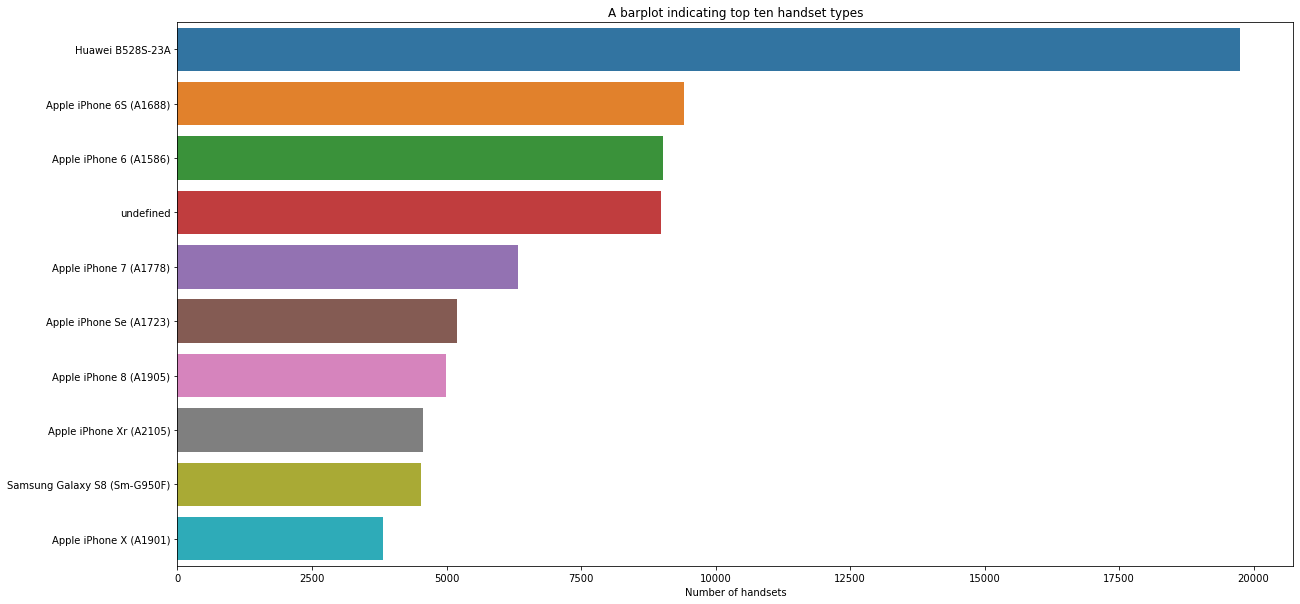

In [413]:
plt.figure(figsize=(20,10))
sns.barplot(y = top_10_sets.index, x = top_10_sets['Handset Type'])
plt.xlabel('Number of handsets')
plt.title('A barplot indicating top ten handset types')

### Bottom 10 handsets

Text(0.5, 1.0, 'A barplot indicating bottom ten handset types')

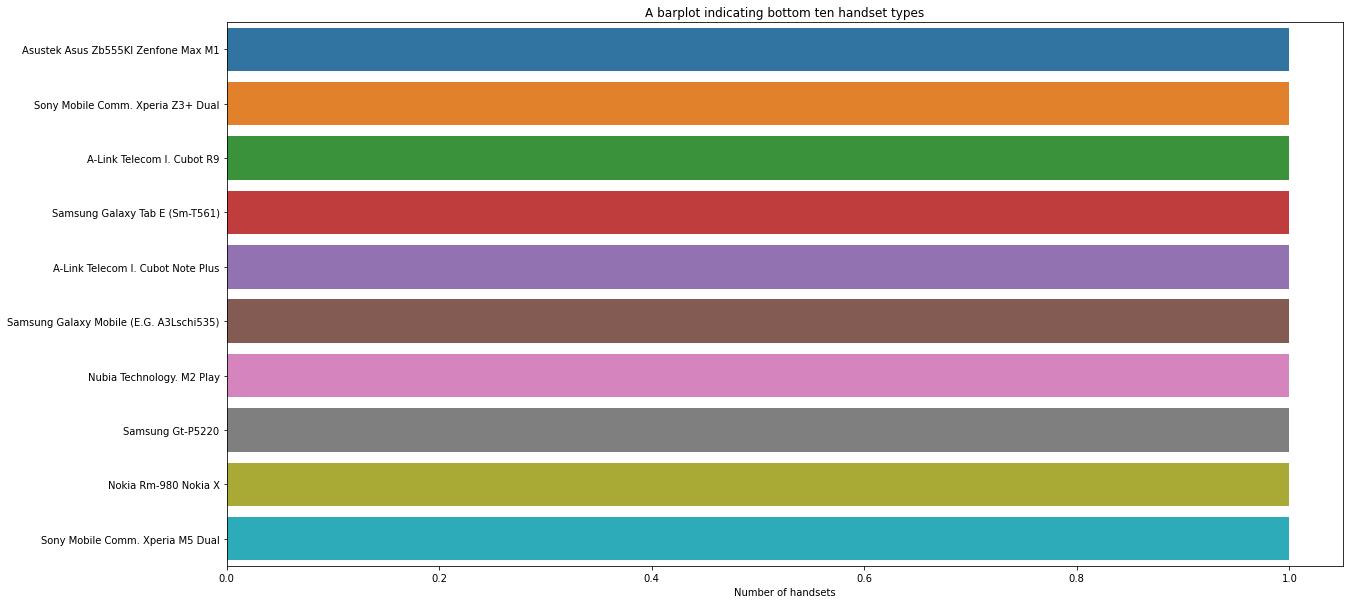

In [414]:
b_10 = data['Handset Type'].value_counts(ascending = False).tail(10)
b_10 = pd.DataFrame(b_10)

plt.figure(figsize=(20,10))
sns.barplot(y = b_10.index, x = b_10['Handset Type'])
plt.xlabel('Number of handsets')
plt.title('A barplot indicating bottom ten handset types')

### top 3 handset manufacturers

In [415]:
top_3_manufacturers = data['Handset Manufacturer'].value_counts(ascending = False).head(3)
top_3_manufacturers = pd.DataFrame(top_3_manufacturers)
top_3_manufacturers

,Handset Manufacturer
Apple,59565
Samsung,40839
Huawei,34423


Text(0.5, 1.0, 'A barplot indicating top 3 handset manufacturers')

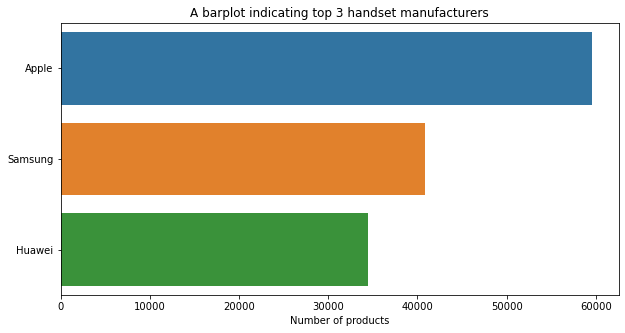

In [416]:
plt.figure(figsize=(10,5))
sns.barplot(y = top_3_manufacturers.index, x = top_3_manufacturers['Handset Manufacturer'])
plt.xlabel('Number of products')
plt.title('A barplot indicating top 3 handset manufacturers')

### Bottom 3 manufacturers

Text(0.5, 1.0, 'A barplot indicating bottom 3 handset manufacturers')

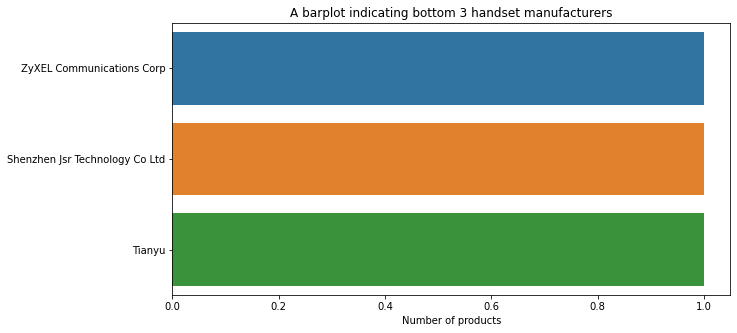

In [417]:
b3 = data['Handset Manufacturer'].value_counts(ascending = False).tail(3)
b3 = pd.DataFrame(b3)

plt.figure(figsize=(10,5))
sns.barplot(y = b3.index, x = b3['Handset Manufacturer'])
plt.xlabel('Number of products')
plt.title('A barplot indicating bottom 3 handset manufacturers')

###  top 5 handsets per handset manufacturer

In [418]:
a = data.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name = 'count').sort_values(['Handset Manufacturer', 'count'], ascending = False).groupby('Handset Manufacturer').head(5)
a.tail(20)

,Handset Manufacturer,Handset Type,count
66,Apple,Apple iPhone 7 (A1778),6326
80,Apple,Apple iPhone Se (A1723),5187
73,Apple,Apple iPhone 8 (A1905),4993
24,Alif Communications,Alif Communicati. Pulian Cm84,1
23,Adar,Adar Stanley Mobile S231,1
20,Acer,Acer M310,5
19,Acer,Acer Liquid Zest Plus,2
14,Acer,Acer Liquid M220,1
15,Acer,Acer Liquid Z220,1
16,Acer,Acer Liquid Z530,1


In [419]:
# data.groupby(["Handset Manufacturer", 'Handset Type'])['Handset Type'].count().reset_index(name='Count')
# b = pd.DataFrame(data.groupby(['Handset Manufacturer', 'Handset Type']).size()).groupby('Handset Manufacturer')
# b = b.apply(lambda _df: _df.sort_values(by=['Handset Manufacturer'], ascending = False))
# b.head(20)
# data[data['Handset Type'] == 'Apple iPhone 7 (A1778)'].shape

In [420]:
# data.groupby('Handset Manufacturer')['Handset Type'].value_counts().unstack(0).plot.barh()

### Make a short interpretation and recommendation to marketing teams

* Apple, Huawei and Samsung are the leading manufacturers. The top 10 handsets also are manufactured by these companies. Some of the bottom 10 handsets also belong to these manufacturers. Thus the volume of the most common handsets should be increased to replace the least common sets. 
* Products from the bottom 3 manufacturers should no longer be stocked. Their extremely small volume matches small profit percentage in comparison to other manufacturers.

### Aggregate per user the following information in the column:

1.  number of xDR sessions

In [421]:
xdr_sess = data[['Bearer Id', 'MSISDN/Number']]
a = xdr_sess.groupby('MSISDN/Number').count()
a.columns = ['xdr sessions']
a.head()

,xdr sessions
MSISDN/Number,
3.360100e+10,1
3.360100e+10,1
3.360100e+10,1
3.360101e+10,1
3.360101e+10,2


Text(0.5, 1.0, 'users with highest session numbers')

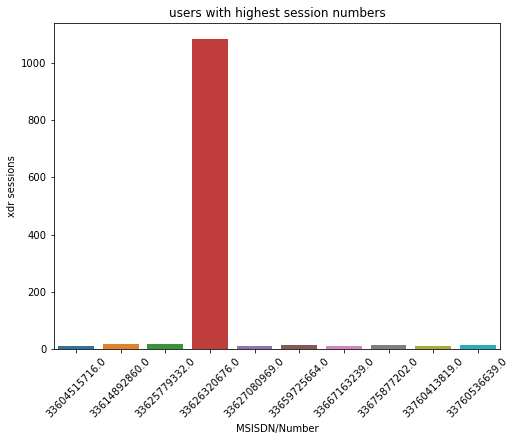

In [422]:
t = a.sort_values(by = 'xdr sessions', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['xdr sessions'])
plt.xticks(rotation = 45)
plt.title('users with highest session numbers')

2.  Session duration

In [423]:
duration = data[['Dur. (ms)', 'MSISDN/Number']]
b = duration.groupby('MSISDN/Number').sum()
b.columns = ['sess_duration (ms)']
b.head()

,sess_duration (ms)
MSISDN/Number,
3.360100e+10,116720.0
3.360100e+10,181230.0
3.360100e+10,134969.0
3.360101e+10,49878.0
3.360101e+10,37104.0


Text(0.5, 1.0, 'users with longest session duration')

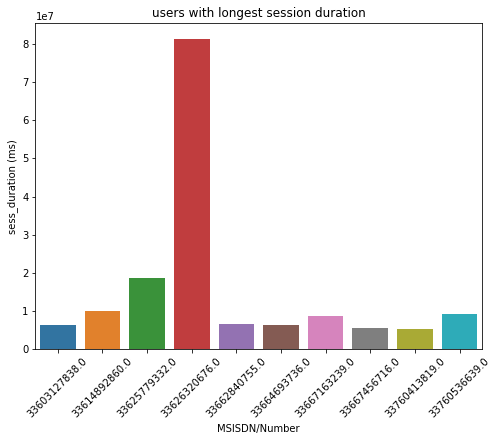

In [424]:
t = b.sort_values(by = 'sess_duration (ms)', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['sess_duration (ms)'])
plt.xticks(rotation = 45)
plt.title('users with longest session duration')

3. The total download (DL) and upload (UL) data

In [425]:
byte = data[['MSISDN/Number', 'Total UL (Bytes)', 'Total DL (Bytes)', 'total_bytes']]
c = byte.groupby('MSISDN/Number').sum()
c.head()

,Total UL (Bytes),Total DL (Bytes),total_bytes
MSISDN/Number,,,
3.360100e+10,36053108.0,8.426375e+08,8.786906e+08
3.360100e+10,36104459.0,1.207552e+08,1.568596e+08
3.360100e+10,39306820.0,5.566597e+08,5.959665e+08
3.360101e+10,20327526.0,4.019932e+08,4.223207e+08
3.360101e+10,94280527.0,1.363130e+09,1.457411e+09


Text(0.5, 1.0, 'A sample of users upload, download and total bytes')

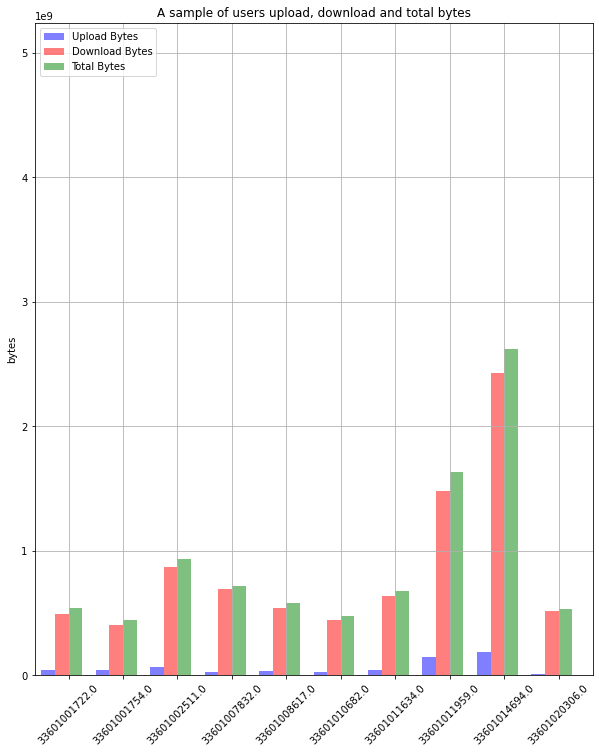

In [426]:
# plotting a sample of the data
t = c.sample(10)
pos = list(range(len(t['Total UL (Bytes)'])))
width = 0.25
fig, ax = plt.subplots(figsize=(10,12))
plt.bar(pos, t['Total UL (Bytes)'], width, alpha=0.5, color='b')
plt.bar([p + width for p in pos], t['Total DL (Bytes)'], width, alpha=0.5, color='r')
plt.bar([p + width*2 for p in pos], t['total_bytes'], width, alpha=0.5, color='g')
ax.set_ylabel('bytes')
ax.set_title('Bytes data per user')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(c.index)
plt.xticks(rotation = 45)

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(t['Total UL (Bytes)'] + t['Total DL (Bytes)'] + t['total_bytes'])] )
plt.legend(['Upload Bytes', 'Download Bytes', 'Total Bytes'], loc='upper left')
plt.grid()
plt.title('A sample of users upload, download and total bytes')

1. Upload bytes are less than download bytes throughout.

4. The total data volume (in Bytes) during this session for each application

In [427]:
# I had already created total bytes columns for all the applications.
apps = data[['MSISDN/Number','social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]
d = apps.groupby('MSISDN/Number').sum()
d.head()

,social_media,google,email,youtube,netflix,gaming,other
MSISDN/Number,,,,,,,
3.360100e+10,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
3.360100e+10,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
3.360100e+10,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3.360101e+10,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
3.360101e+10,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


In [428]:
# sns.barplot(x=d.index.head(), y=, hue='variable', data=df1)
# plt.xticks(rotation=90)
# plt.ylabel('Returns')
# plt.title('Portfolio vs Benchmark Returns');

## Non-Graphical Univariate Analysis

Variables of interest: Number of xDR sessions,  Session duration,  the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).

### Dispersion and Central Tendency

In [429]:
# data.describe()

In [430]:
# variables = data[['Bearer Id', 'Dur. (ms).1', 'Total UL (Bytes)', 'Total DL (Bytes)', 'social_media', 'netflix', 'gaming', 'youtube', 'google', 'email', 'other']]
# variables.describe()

In [431]:
variables = data[['Bearer Id', 'Dur. (ms).1', 'Total UL (Bytes)', 'Total DL (Bytes)', 'social_media', 'netflix',
                  'gaming', 'youtube', 'google', 'email', 'other', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
                 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]
variables.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Dur. (ms).1,150001.0,1.046091e+08,8.103734e+07,7142988.0,57442058.0,8.639998e+07,1.324307e+08,1.859336e+09
Total UL (Bytes),150001.0,4.112121e+07,1.127635e+07,2866892.0,33222029.0,4.114324e+07,4.903424e+07,7.833131e+07
Total DL (Bytes),150001.0,4.546434e+08,2.441421e+08,7114041.0,243107173.0,4.558409e+08,6.657051e+08,9.029696e+08
social_media,150001.0,1.828250e+06,1.035646e+06,1563.0,932218.0,1.826471e+06,2.727487e+06,3.650861e+06
netflix,150001.0,2.262861e+07,9.260820e+06,98432.0,15979455.0,2.263554e+07,2.929044e+07,4.519815e+07
gaming,150001.0,4.303331e+08,2.440199e+08,306358.0,218727939.0,4.316150e+08,6.414159e+08,8.592028e+08
youtube,150001.0,2.264348e+07,9.246800e+06,78903.0,15998463.0,2.266177e+07,2.929260e+07,4.519008e+07
google,150001.0,7.807295e+06,3.516420e+06,40330.0,4943599.0,7.812835e+06,1.068280e+07,1.552878e+07
email,150001.0,2.259102e+06,1.071109e+06,8359.0,1359344.0,2.263567e+06,3.159818e+06,4.518036e+06
other,150001.0,4.293653e+08,2.432681e+08,149045.0,218553417.0,4.299865e+08,6.399275e+08,8.595209e+08


In [432]:
data['Bearer Id'].nunique()

134709

In [433]:
# skewness and kurtosis
s = variables.skew(axis = 0, skipna = True) 
k = variables.kurt(axis = 0, skipna = True) 
pd.DataFrame([s, k], index = ['skewness', 'kurtosis'])

,Dur. (ms).1,Total UL (Bytes),Total DL (Bytes),social_media,netflix,gaming,youtube,google,email,other,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
skewness,3.952622,-0.002456,-0.003153,-0.002121,-0.000409,-0.003225,-0.005465,-0.010602,-0.006033,0.001256,69.705161,31.530109,2.589445,4.503428,24.840677,141.035684
kurtosis,37.022470,-0.327436,-1.198363,-1.202178,-0.608472,-1.202256,-0.604624,-0.963035,-1.061696,-1.196015,8805.687875,1632.646032,9.573691,25.086860,697.574773,21913.803296


Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

Approximately symmetric distribution: If the skewness value is between −½ and +½.


Really Flat distribution: Kurtosis less than -1.
Peaked distribution: Kurtosis more than 1.

Summary of some of the variables:


1. **Bearer Id** ~ This is the session identifier, thus not quantitative. It has 134709 instances thus the recorded number of xDR sessions are 134709.
2. **Dur. (ms).1** ~ This is the total duration of an xDR session in micro seconds. Across the 134709 sessions, it has the following measures:
    * Average:          	1.046091e+08
    * Standard Deviation: 	8.103734e+07
    * Minimum Value:     	7.142988e+06 	
    * Lower Quartile    	5.744206e+07 	
    * Median            	8.639998e+07 	 
    * Upper Quartile     	1.324307e+08
    * Maximum Value:    	1.859336e+09 		
    
    
3. **Total UL (Bytes)** ~ Data volume in bytes sent during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.112121e+07
    * Standard Deviation: 	1.127635e+07  
    * Minimum Value:     	2.866892e+06 
    * Lower Quartile    	3.322203e+07 
    * Median            	4.558409e+08
    * Upper Quartile     	4.903424e+07 
    * Maximum Value:    	7.833131e+07 
    
    
4. **Total DL (Bytes)** ~ Data volume in bytes received during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.546434e+085
    * Standard Deviation: 	2.441421e+08 
    * Minimum Value:     	7.114041e+06 
    * Lower Quartile    	2.431072e+08 
    * Median            	1.826471e+06 
    * Upper Quartile     	6.657051e+08 
    * Maximum Value:    	9.029696e+08  
    
    
5. **social_media** ~ Total social media data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	1.828250e+06
    * Standard Deviation: 	1.035646e+06
    * Minimum Value:     	1.563000e+03
    * Lower Quartile    	9.322180e+05
    * Median            	8.639900e+04
    * Upper Quartile     	2.727487e+06 
    * Maximum Value:    	3.650861e+06 
   
   
   
6. **netflix** ~ Total netflix data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.262861e+07 
    * Standard Deviation: 	9.260820e+06 
    * Minimum Value:     	9.843200e+04 
    * Lower Quartile    	1.597946e+07
    * Median            	2.263554e+07 
    * Upper Quartile     	2.929044e+07 
    * Maximum Value:    	4.519815e+07 
    
    
7. **gaming** ~ Total gaming data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.303331e+08 
    * Standard Deviation: 	2.440199e+08 
    * Minimum Value:     	3.063580e+05
    * Lower Quartile    	2.187279e+08
    * Median            	4.316150e+08 
    * Upper Quartile     	6.414159e+08 
    * Maximum Value:    	8.592028e+08 
    
    
8. **youtube)** ~ Total youtube data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.264348e+07 
    * Standard Deviation: 	9.246800e+06 
    * Minimum Value:     	7.890300e+04
    * Lower Quartile    	1.599846e+07 
    * Median            	2.266177e+07
    * Upper Quartile     	2.929260e+07
    * Maximum Value:    	4.519008e+07 
    
    
9. **email** ~ Total email data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.259102e+06 
    * Standard Deviation: 	1.071109e+06 
    * Minimum Value:     	8.359000e+03 
    * Lower Quartile    	1.359344e+06
    * Median            	2.263567e+06
    * Upper Quartile     	3.159818e+06 
    * Maximum Value:    	4.518036e+06
    
    
10. **google** ~ Total google data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	7.807295e+06 
    * Standard Deviation: 	3.516420e+06 
    * Minimum Value:     	4.033000e+04 
    * Lower Quartile    	4.943599e+06 
    * Median            	7.812835e+06
    * Upper Quartile     	1.068280e+07 
    * Maximum Value:    	1.552878e+07 
    
    
    
11. **other** ~ Total Other data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.293653e+08
    * Standard Deviation: 	2.432681e+08
    * Minimum Value:     	1.490450e+05
    * Lower Quartile    	2.185534e+08
    * Median            	4.299865e+08
    * Upper Quartile     	6.399275e+08
    * Maximum Value:    	8.595209e+08



### Outlier Detection

In [434]:
# Outlier detection

# chauvenets creterion (assumes normally distributed data)

# def chauvenet(array):
#     mean = array.mean()           # Mean of incoming array
#     stdv = array.std()            # Standard deviation
#     N = len(array)                # Lenght of incoming array
#     criterion = 1.0/(2*N)         # Chauvenet's criterion
#     d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
#     prob = erfc(d)                # Area normal dist.    
#     return prob < criterion       # Use boolean array outside this function#

#zscore (assumes normal distribution too. not good)


In [435]:

#IQR

#google
Q1 = np.percentile(data.google, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.google, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.google, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.google, interpolation = 'midpoint') 
o = (data.google < (Q1 - 1.5 * IQR)) |(data.google > (Q3 + 1.5 * IQR))
i = o.unique()

#youtube
Q1 = np.percentile(data.youtube, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.youtube, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.youtube, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.youtube, interpolation = 'midpoint') 
o = (data.youtube < (Q1 - 1.5 * IQR)) |(data.youtube > (Q3 + 1.5 * IQR))
j = o.unique()

#gaming
Q1 = np.percentile(data.gaming, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.gaming, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.gaming, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.gaming, interpolation = 'midpoint') 
o = (data.gaming < (Q1 - 1.5 * IQR)) |(data.gaming > (Q3 + 1.5 * IQR))
k = o.unique()


#netflix
Q1 = np.percentile(data.netflix, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.netflix, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.netflix, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.netflix, interpolation = 'midpoint') 
o = (data.netflix < (Q1 - 1.5 * IQR)) |(data.netflix > (Q3 + 1.5 * IQR))
l = o.unique()


#email
Q1 = np.percentile(data.email, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.email, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.email, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.email, interpolation = 'midpoint') 
o = (data.email < (Q1 - 1.5 * IQR)) |(data.email > (Q3 + 1.5 * IQR))
m = np.unique(o)


#social_media
Q1 = np.percentile(data.social_media, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.social_media, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.social_media, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.social_media, interpolation = 'midpoint') 
o = (data.social_media < (Q1 - 1.5 * IQR)) |(data.social_media > (Q3 + 1.5 * IQR))
n = o.unique()

#others
Q1 = np.percentile(data.other, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.other, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.other, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.other, interpolation = 'midpoint') 
o = (data.other < (Q1 - 1.5 * IQR)) |(data.other > (Q3 + 1.5 * IQR))
p = o.unique()




['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
                 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']
#Dur. (ms).1
Q1 = np.percentile(data['Dur. (ms).1'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(data['Dur. (ms).1'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(data['Dur. (ms).1'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(data['Dur. (ms).1'], interpolation = 'midpoint') 
o = (data['Dur. (ms).1'] < (Q1 - 1.5 * IQR)) |(data['Dur. (ms).1'] > (Q3 + 1.5 * IQR))
q = o.unique()

#total_bytes
Q1 = np.percentile(data.total_bytes, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_bytes, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_bytes, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_bytes, interpolation = 'midpoint') 
o = (data.total_bytes < (Q1 - 1.5 * IQR)) |(data.total_bytes > (Q3 + 1.5 * IQR))
r = o.unique()

#total_tp
Q1 = np.percentile(data.total_tp, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_tp, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_tp, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_tp, interpolation = 'midpoint') 
o = (data.total_tp < (Q1 - 1.5 * IQR)) |(data.total_tp > (Q3 + 1.5 * IQR))
s = o.unique()

#total_rtt
Q1 = np.percentile(data.total_rtt, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_rtt, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_rtt, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_rtt, interpolation = 'midpoint') 
o = (data.total_rtt < (Q1 - 1.5 * IQR)) |(data.total_rtt > (Q3 + 1.5 * IQR))
t = o.unique()

#total_tcp
Q1 = np.percentile(data.total_tcp, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.total_tcp, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.total_tcp, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.total_tcp, interpolation = 'midpoint') 
o = (data.total_tcp < (Q1 - 1.5 * IQR)) |(data.total_tcp > (Q3 + 1.5 * IQR))
u = o.unique()


print('google', i)
print('youtube', j)
print('gaming', k)
print('netflix', l)
print('email', m)
print('social media', n)
print('other', p)
print('Duration', q)
print('total bytes', r)
print('total_tp', s)
print('total_rtt', t)
print('total_tcp', u)

google [False]
youtube [False]
gaming [False]
netflix [False]
email [False]
social media [False]
other [False]
Duration [ True False]
total bytes [False]
total_tp [False  True]
total_rtt [False  True]
total_tcp [False  True]


No outliers present in the apps.
Outliers present in the **session duration, total throughput, total rtt*** and ***total tcp**. This will be taken care of in a later section.

Same method will be extended to other columns.

## Graphical Univariate Analysis.

Variables of interest: Number of xDR sessions, Session duration, the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).

For graphical analysis of univariate categorical data, histograms are typically used. The histogram represents the frequency (count) or proportion (count/total count) of cases for a range of values. Typically, between about 5 and 30 bins are chosen. Histograms are one of the best ways to quickly learn a lot about your data, including central tendency, spread, modality, shape and outliers. Stem and Leaf plots could also be used for the same purpose. Boxplots can also be used to present  information about the central tendency, symmetry and skew, as well as outliers.  Quantile normal plots or QQ plots and other techniques could also be used here.

Number of xDR sessions,  Session duration,  the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).


 mu = 430333100.71 and sigma = 244019110.62



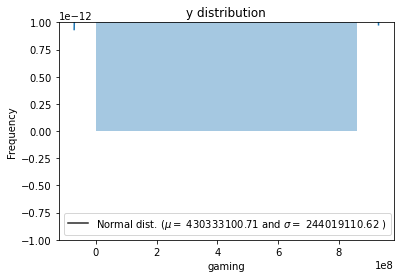

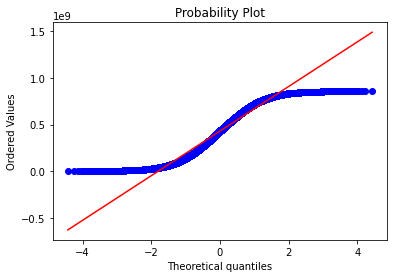

In [436]:
sns.distplot(data['gaming'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['gaming'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['gaming'], plot=plt)
plt.show()


 mu = 22628606.54 and sigma = 9260789.22



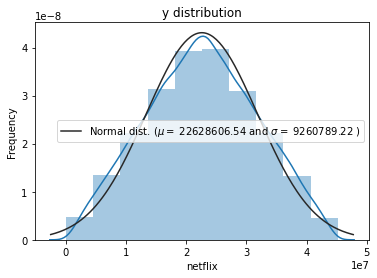

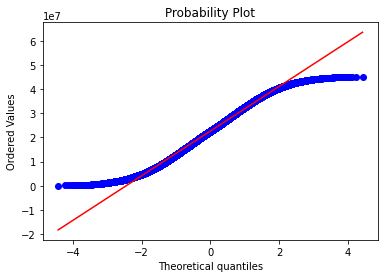

In [437]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['netflix'] , bins = 10, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['netflix'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['netflix'], plot=plt)
plt.show()


 mu = 22643482.64 and sigma = 9246769.48



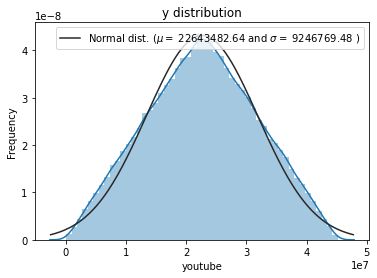

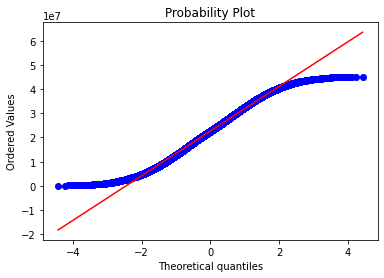

In [438]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['youtube'] , fit=norm);
# sns.violinplot(data['youtube'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['youtube'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['youtube'], plot=plt)
plt.show()


 mu = 2259102.31 and sigma = 1071105.49



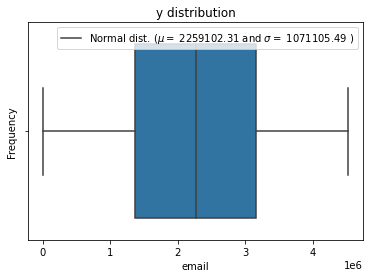

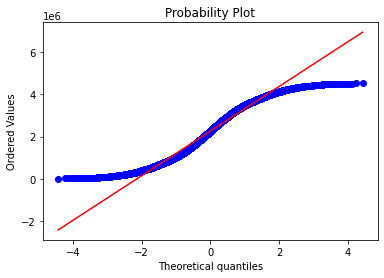

In [439]:
# sns.distplot(data['email'], fit = norm) # numeric
sns.boxplot(data['email'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['email'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['email'], plot=plt)
plt.show()


 mu = 7807294.55 and sigma = 3516408.52



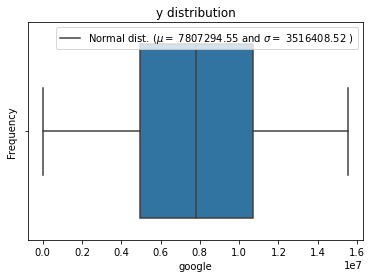

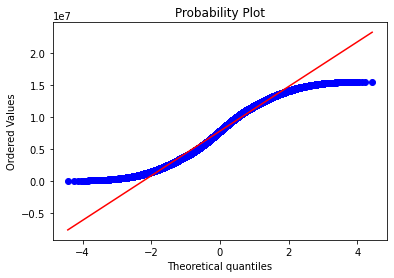

In [440]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
# sns.distplot(data['google'] , fit=norm);
sns.boxplot(data['google'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['google'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['google'], plot=plt)
plt.show()


 mu = 1828250.21 and sigma = 1035642.69



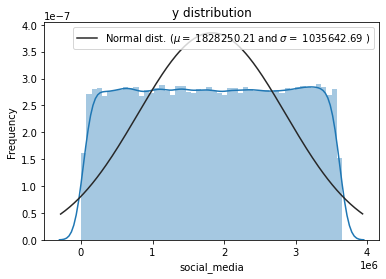

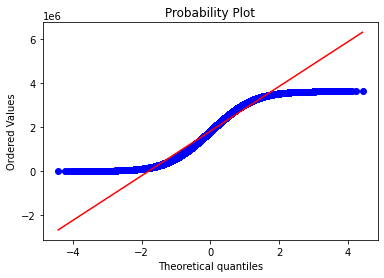

In [441]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['social_media'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['social_media'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['social_media'], plot=plt)
plt.show()


 mu = 495764636.37 and sigma = 244380172.44



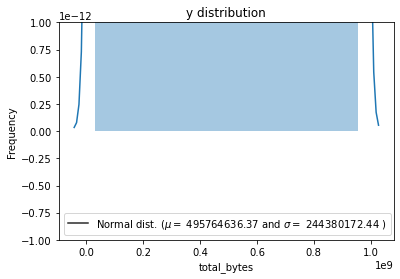

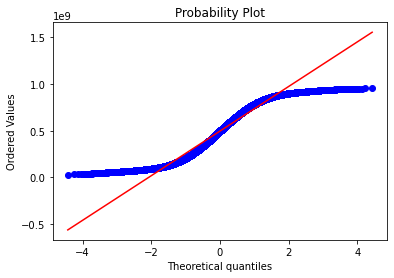

In [442]:
# total upload and download bytes
sns.distplot(data['total_bytes'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['total_bytes'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_bytes'], plot=plt)
plt.show()


 mu = 104609105.55 and sigma = 81037071.33



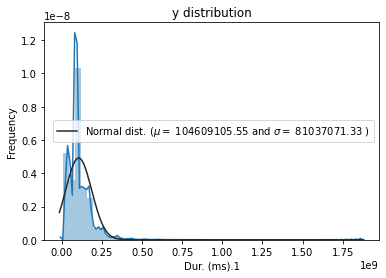

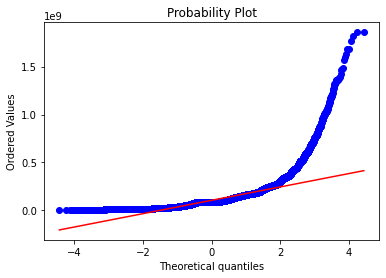

In [443]:
# xdr ms
sns.distplot(data['Dur. (ms).1'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['Dur. (ms).1'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['Dur. (ms).1'], plot=plt)
plt.show()

Heavily rightly skewed.


 mu = 15070.47 and sigma = 26825.67



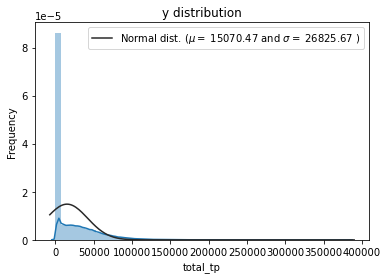

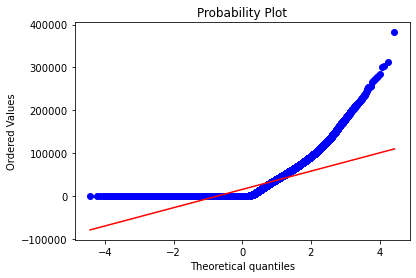

In [444]:
# total_tp
sns.distplot(data['total_tp'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['total_tp'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_tp'], plot=plt)
plt.show()

Heavily skewed to the right.


 mu = 127.46 and sigma = 565.14



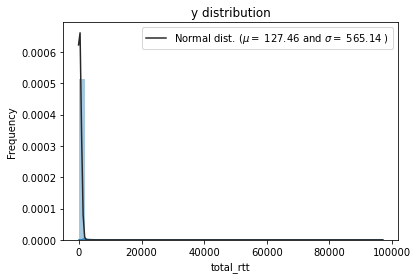

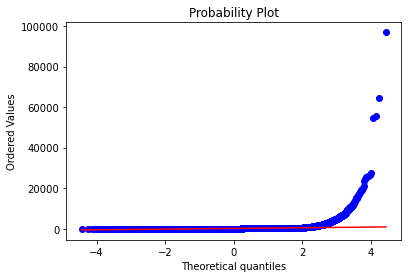

In [445]:
# total_rtt
sns.distplot(data['total_rtt'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['total_rtt'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_rtt'], plot=plt)
plt.show()

Right tailed too.


 mu = 21569572.94 and sigma = 118438811.90



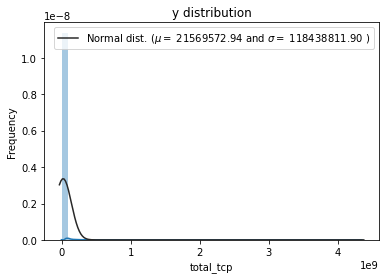

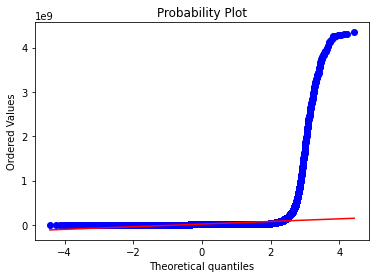

In [446]:
# total_tcp
sns.distplot(data['total_tcp'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['total_tcp'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_tcp'], plot=plt)
plt.show()

## Bivariate Analysis
– explore the relationship between each application & the total DL+UL data using appropriate methods and interpret your findings.

(Social Media, Google, Email, YouTube, Netflix, Gaming ++ total_bytes).

In [447]:
# data['total'] = data['Total DL (Bytes)'] + data['Total UL (Bytes)']
# sns.barplot(x = data['social_media'], y = data['total'])

biv_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'total_bytes', 'other']]
# adding a summation row in all columns
biv_data.loc['totals'] = biv_data.sum()
biv_data.tail()

,social_media,google,email,youtube,netflix,gaming,total_bytes,other
149997,2.352181e+06,4.415361e+06,2.121718e+06,2.216552e+07,4.064329e+07,6.316281e+08,7.057839e+08,7.146381e+08
149998,1.260239e+06,6.585469e+06,2.058277e+06,2.451641e+07,1.502970e+07,5.669338e+08,6.276986e+08,1.324156e+08
149999,8.231090e+05,7.757267e+06,2.850914e+06,1.712251e+07,1.649484e+07,3.550664e+08,4.015220e+08,8.161200e+08
150000,1.828250e+06,7.807295e+06,2.259102e+06,2.264348e+07,2.262861e+07,4.303331e+08,4.957646e+08,4.293653e+08
totals,2.742394e+11,1.171102e+12,3.388676e+11,3.396545e+12,3.394314e+12,6.455040e+13,7.436519e+13,6.440523e+13


### Applications total bytes

Text(0.5, 0, 'application')

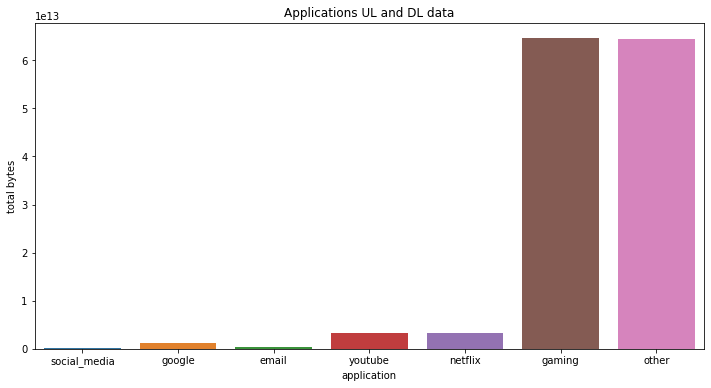

In [448]:
a = biv_data.tail(1)
long_df = pd.melt(a)
long_df = long_df.drop([6], axis  = 0)
plt.figure(figsize=(12,6))
sns.barplot(x = long_df.variable, y = long_df.value)
plt.title('Applications UL and DL data')
plt.ylabel('total bytes')
plt.xlabel('application')

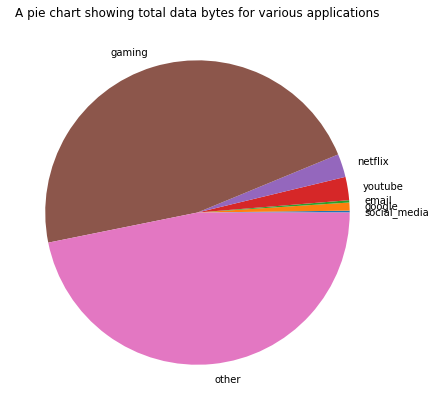

In [449]:
fig = plt.figure(figsize =(10, 7)) 
a = biv_data.drop(['total_bytes'], axis = 1)
plt.pie(a.loc['totals'], labels = a.columns)
plt.title('A pie chart showing total data bytes for various applications')
plt.show()



Will you look at that!!!
Gamers Republic!!
*  The large percentage of **others** can be explained by many applications under the name others.
*  As for gaming:
  1. The applications are heavy. (Require more data)
  2. Most of the users are gamers.
  3. Most of the applications in the hand sets are games.

#### One on one plots on the apps vs total_bytes

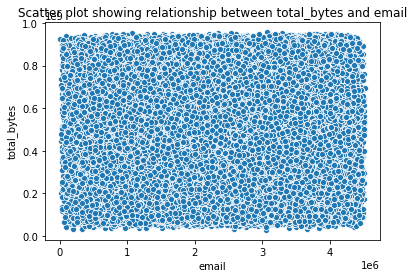

In [450]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='email', y='total_bytes')
plt.title('Scatter plot showing relationship between total_bytes and email')
plt.show()

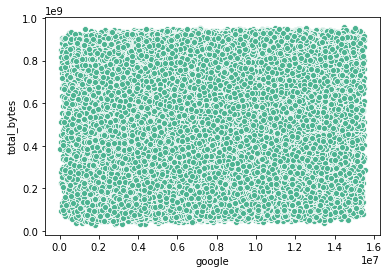

In [451]:
plt.figure(figsize=(6, 4))
# sns.jointplot(data = data, x='google', y='total_bytes', kind = 'hex', color = '#4CB391')
sns.scatterplot(data = data, x='google', y='total_bytes', color = '#4CB391')
# plt.title('Hexplot plot showing relationship between total_bytes and google', size=20)
plt.show()

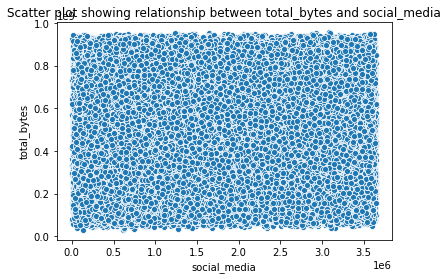

In [452]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='social_media', y='total_bytes')
plt.title('Scatter plot showing relationship between total_bytes and social_media')
plt.show()

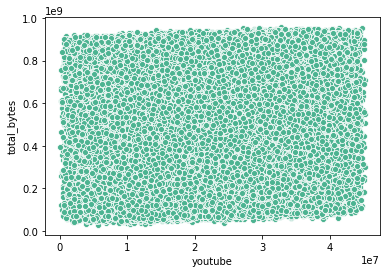

In [453]:
plt.figure(figsize=(6, 4))
# sns.jointplot(data = data, x='youtube', y='total_bytes', kind = 'hex', color = '#4CB391')
sns.scatterplot(data = data, x='youtube', y='total_bytes', color = '#4CB391')
# plt.title('Hexplot plot showing relationship between total_bytes and youtube')
plt.show()

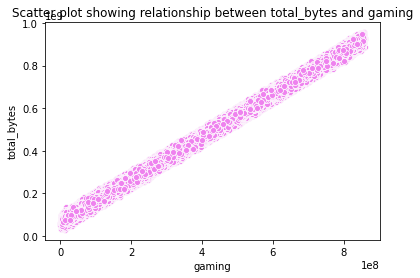

In [454]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='gaming', y='total_bytes', color = 'violet')
plt.title('Scatter plot showing relationship between total_bytes and gaming')
plt.show()

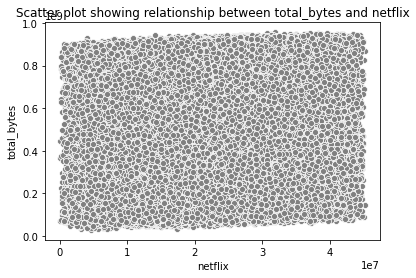

In [455]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data = data, x='netflix', y='total_bytes', color = 'grey')
plt.title('Scatter plot showing relationship between total_bytes and netflix')
plt.show()

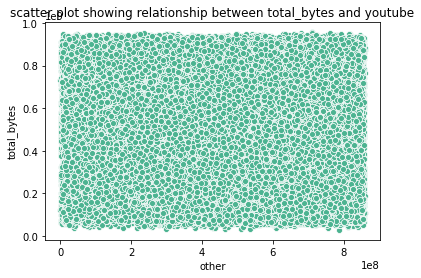

In [456]:
plt.figure(figsize=(6, 4))
# sns.jointplot(data = data, x='other', y='total_bytes', kind = 'hex', color = '#4CB391')
sns.scatterplot(data = data, x='other', y='total_bytes', color = '#4CB391')
plt.title('scatter plot showing relationship between total_bytes and youtube')
plt.show()

## Variable transformations
– segment the users into top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class.

In [457]:
# adding Decile_rank column to the DataFrame 
data['Decile_rank'] = pd.qcut(data['Dur. (ms).1'], 5, labels = False) 
# data.columns

In [458]:
new_df = data[['Decile_rank', 'total_bytes']]
a = new_df.groupby('Decile_rank').sum()
a

,total_bytes
Decile_rank,
0,1.488404e+13
1,1.492541e+13
2,1.478282e+13
3,1.485458e+13
4,1.491834e+13


Text(0.5, 0, 'decile rank')

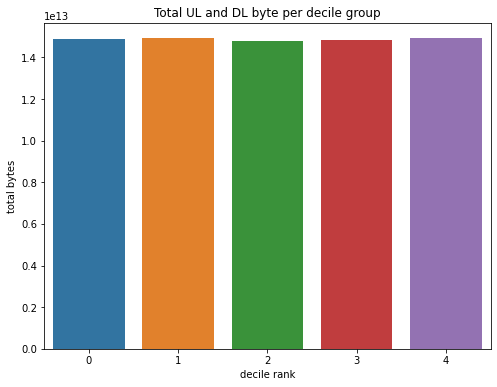

In [459]:
plt.figure(figsize=(8,6))
sns.barplot(x = a.index, y = a.total_bytes)
plt.title('Total UL and DL byte per decile group')
plt.ylabel('total bytes')
plt.xlabel('decile rank')

## Correlation Analysis
– compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data - (jupyter notebook + slide )

### correlation on the total bytes

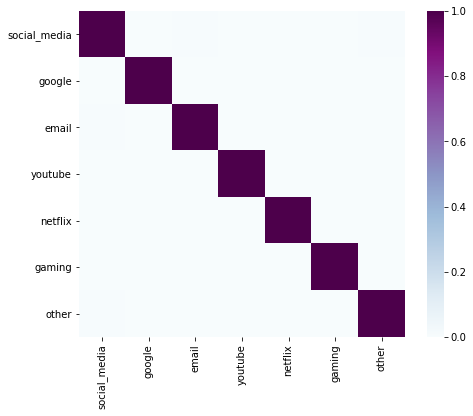

In [460]:
corr_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(8, 6))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

### On the upload bytes

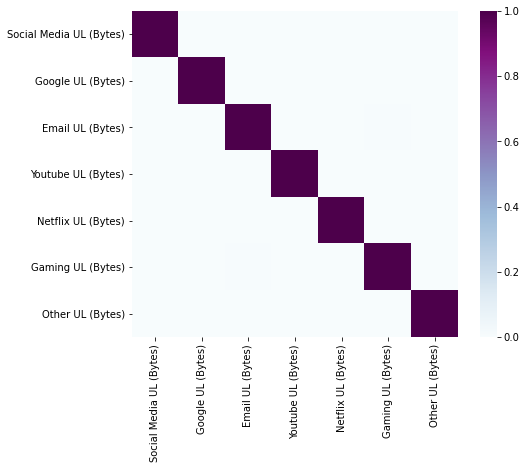

In [461]:
corr_data = data[['Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)', 'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(8, 6))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

### On the download bytes

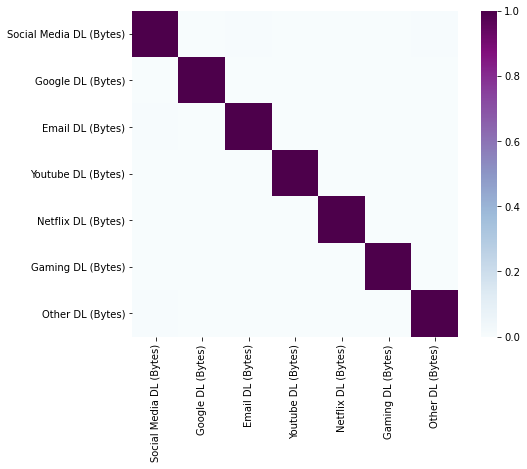

In [462]:
corr_data = data[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(8, 6))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

## Dimensionality Reduction
– perform a principal component analysis to reduce the dimensions of your data and provide a useful interpretation of the results.

In [463]:
# standardize the data
from sklearn.preprocessing import StandardScaler


new_numerical = [] #this leaves out the categorical columns that were encoded but not replaced
for col in data.columns:
    if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        new_numerical.append(col)
        
seg = data[new_numerical].copy()
seg = seg.drop(['MSISDN/Number'], axis = 1) #drop the id col
scaler = StandardScaler()
scaled_data = scaler.fit_transform(seg)

In [464]:
scaled_data.shape

(150001, 64)

In [465]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [466]:
pca.explained_variance_ratio_

array([1.27522336e-01, 6.24869936e-02, 5.19284068e-02, 4.50661462e-02,
       3.98179627e-02, 3.54375697e-02, 3.26264099e-02, 3.16059460e-02,
       3.14474506e-02, 3.12652367e-02, 3.10646866e-02, 3.09406230e-02,
       3.03966735e-02, 2.74444877e-02, 2.60435371e-02, 2.34183567e-02,
       2.27603861e-02, 2.18063706e-02, 1.76146270e-02, 1.75153249e-02,
       1.57778992e-02, 1.57394322e-02, 1.56751263e-02, 1.56198681e-02,
       1.56008199e-02, 1.55187372e-02, 1.54685100e-02, 1.54585070e-02,
       1.51929289e-02, 1.42550666e-02, 1.37188255e-02, 1.22995803e-02,
       1.14066526e-02, 1.08711957e-02, 9.57101408e-03, 8.33769608e-03,
       7.60538635e-03, 6.56871031e-03, 5.87938373e-03, 4.61461484e-03,
       4.50412955e-03, 4.28496289e-03, 2.76039131e-03, 2.41196329e-03,
       1.26093455e-03, 9.93898766e-04, 2.56881895e-04, 6.80110981e-05,
       5.54036997e-05, 1.39362373e-05, 1.16903330e-13, 8.66302518e-32,
       1.61314279e-32, 1.26479289e-32, 8.53164733e-33, 5.35077190e-33,
      

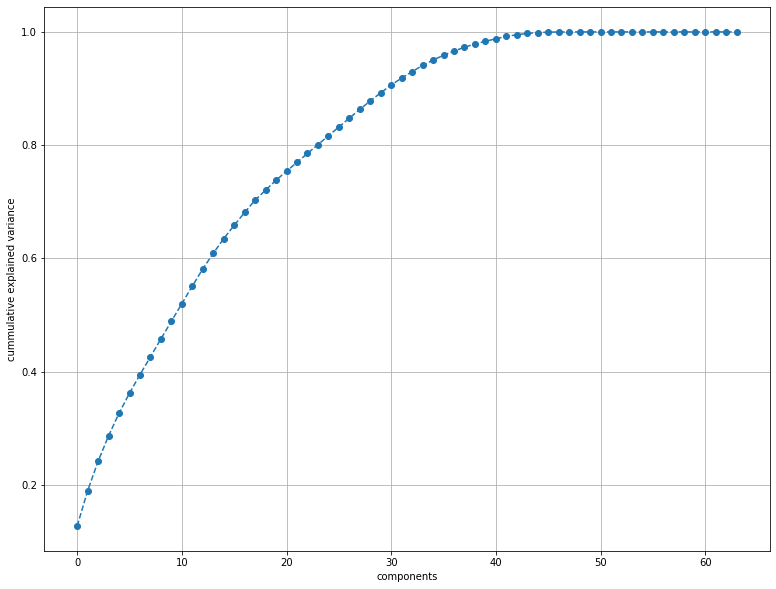

In [467]:
plt.figure(figsize = (13,10))
plt.plot(range(64), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

When choosing the number of components, the number cutting at least 80% of the cumm explained variance is considered.
**n = 23**

In [468]:
pca = PCA(n_components = 23)
pca.fit(scaled_data)

PCA(n_components=23)

In [469]:
pca_scores = pca.transform(scaled_data)

In [470]:
# new_data_df = pd.concat([seg.reset_index(drop = True), pd.DataFrame(pca_scores)], axis = 1)
# c.columns.values[-2:] = ['component1', 'component2']
# new_data_df.head() #contains the original cols 

a = pd.DataFrame(pca_scores)
a['MSISDN/Number'] = data['MSISDN/Number']
a.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,MSISDN/Number
0,-4.339527,1.294861,16.396890,-8.108981,-0.410230,-12.335945,-4.856943,1.568127,1.120406,0.580322,...,0.210107,1.908675,-0.678007,-1.052835,-3.021698,0.214220,0.139861,0.261070,-0.075554,3.366496e+10
1,-3.464658,-1.623907,12.214544,-6.059901,3.425187,-9.195175,-2.963303,-0.754806,-0.579681,2.420647,...,0.225816,1.181047,1.208814,-0.822257,-3.163747,-1.183310,1.962456,-0.237911,1.161021,3.368185e+10
2,-3.514414,1.591795,12.205505,-6.001493,0.388945,-9.209815,-3.076637,-0.244050,-0.151015,-1.483835,...,0.174184,1.141951,2.644049,-0.875521,-2.050632,-1.474581,0.330420,-0.383997,0.517293,3.376063e+10
3,-3.485888,-3.143227,12.015609,-5.993319,0.984735,-9.905759,-1.954446,-1.884639,-2.155462,-0.699031,...,0.239774,1.149684,0.340444,-0.620726,-2.832788,-1.582804,-0.379974,-0.967707,0.747672,3.375034e+10
4,-3.061889,-0.837406,9.788757,-4.803821,0.552689,-7.480438,-2.096321,-1.025217,-1.391161,0.338411,...,0.117241,0.939808,0.784196,-0.562090,-2.378987,0.702210,1.513062,-1.459460,-0.007388,3.369980e+10


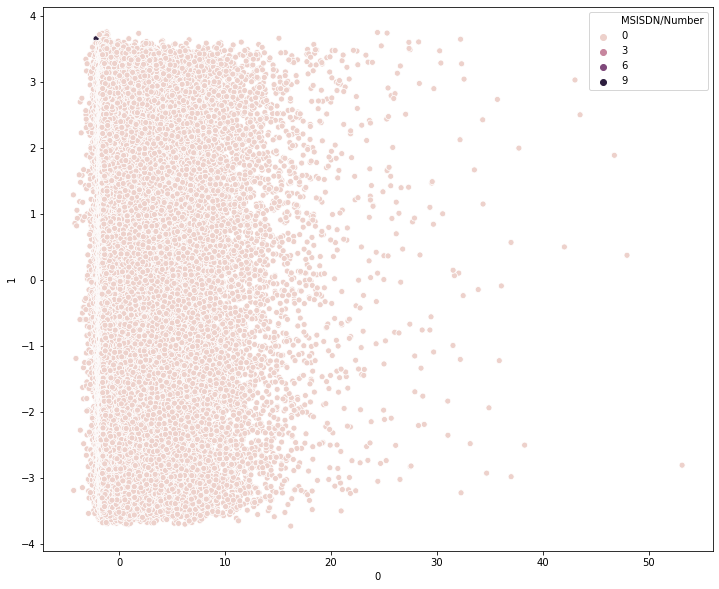

In [471]:
#plotting the first 2 components since they explain most of the variability.
plt.figure(figsize=(12,10))
sns.scatterplot(x= a[0], y = a[1], hue = a['MSISDN/Number'])

## 2. User Engagement analysis
In the current dataset you’re expected to track the user’s engagement using the following engagement metrics: 
* sessions frequency 
* the duration of the session 
* the sessions total traffic (download and upload (bytes))


In [472]:
# data.columns
# data['MSISDN/Number'].nunique()

### * Sessions frequency, sessions duration, sessions total traffic.

In [473]:
user_data = data[['MSISDN/Number', 'total_bytes', 'Dur. (ms).1', 'Bearer Id']]

# def f(x):
#     d = {}
#     d['total_bytes'] = x['total_bytes'].sum()
#     d['Dur. (ms).1'] = x['Dur. (ms).1'].sum()
#     d['Bearer Id'] = x['Bearer Id'].count()
#     return pd.Series(d, index=['total_bytes', 'Dur. (ms).1', 'Bearer Id'])

# user_data.groupby('MSISDN/Number').apply(f)

In [561]:
agg_user_data = user_data.groupby('MSISDN/Number').agg({'Bearer Id':'count', 'Dur. (ms).1':'sum',  'total_bytes': 'sum'})
agg_user_data.columns = ['sessions_freq', 'sessions_duration(ms)', 'sessions_traffic(bytes)']
agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,1,116720140.0,8.786906e+08
3.360100e+10,1,181230963.0,1.568596e+08
3.360100e+10,1,134969374.0,5.959665e+08
3.360101e+10,1,49878024.0,4.223207e+08
3.360101e+10,2,37104453.0,1.457411e+09


### Top 10 users with high sessions frequency

Text(0.5, 1.0, 'a barplot indicating 10 users with highest number of sessions')

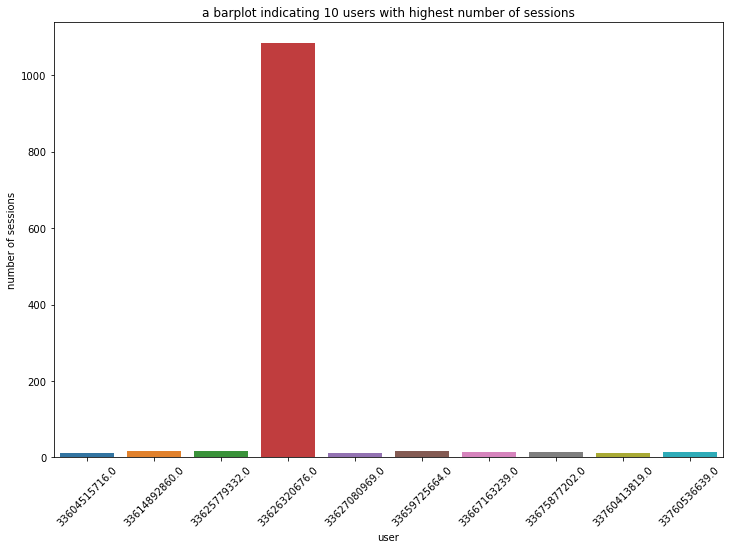

In [475]:
a = agg_user_data.sort_values(by = 'sessions_freq', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = a.index, y = a['sessions_freq'])
plt.ylabel('number of sessions')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest number of sessions')

### Top 10 users with high sessions traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest sessions traffic')

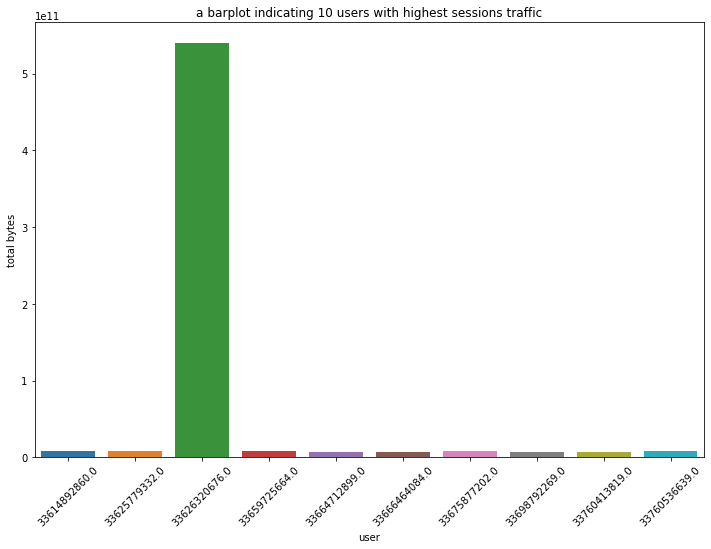

In [476]:
b = agg_user_data.sort_values(by = 'sessions_traffic(bytes)', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['sessions_traffic(bytes)'])
plt.ylabel('total bytes')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest sessions traffic')

### Top 10 users with longest sessions duration

Text(0.5, 1.0, 'a barplot indicating 10 users with longest sessions duration')

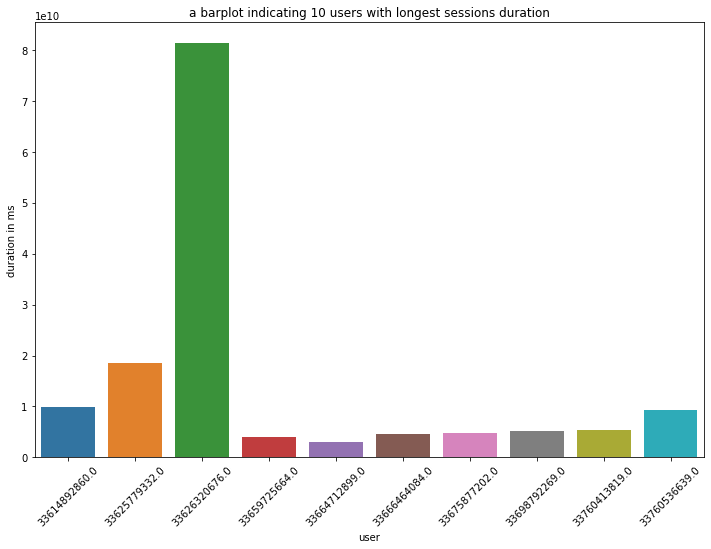

In [477]:
c = agg_user_data.sort_values(by = 'sessions_duration(ms)', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['sessions_duration(ms)'])
plt.ylabel('duration in ms')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with longest sessions duration')

In [478]:
# users in the 3 categories.
a = a.index.to_list()
b = b.index.to_list()
c = c.index.to_list()

def IntersecOfSets(arr1, arr2, arr3): 
    s1 = set(arr1) 
    s2 = set(arr2) 
    s3 = set(arr3) 

    set1 = s1.intersection(s2)
    result_set = set1.intersection(s3) 
      
    final_list = list(result_set) 
    print(final_list) 
  
IntersecOfSets(a, b, c) 

[33625779332.0, 33626320676.0, 33760413819.0, 33614892860.0, 33760536639.0]


### Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement.


In [562]:
# Normalizing the aggregated dataset using log transformation
norm_agg_user_data = np.log1p(agg_user_data)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,0.693147,18.575290,20.593943
3.360100e+10,0.693147,19.015283,18.870862
3.360100e+10,0.693147,18.720558,20.205695
3.360101e+10,0.693147,17.725091,19.861276
3.360101e+10,1.098612,17.429248,21.099927


In [480]:
norm_agg_user_data.shape

(106856, 3)

In [563]:
# kmeans on 3 clusters.
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(norm_agg_user_data)
kmeans_data = kmeans.predict(norm_agg_user_data)

In [564]:
# add the predicted clusters as a column in the df
norm_agg_user_data['clusters'] = pd.Series(kmeans_data, index=norm_agg_user_data.index)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,0.693147,18.575290,20.593943,2
3.360100e+10,0.693147,19.015283,18.870862,2
3.360100e+10,0.693147,18.720558,20.205695,2
3.360101e+10,0.693147,17.725091,19.861276,0
3.360101e+10,1.098612,17.429248,21.099927,0


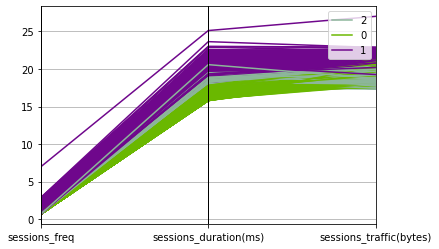

In [483]:
#plot the clusters(3D)
pd.plotting.parallel_coordinates(norm_agg_user_data, 'clusters')

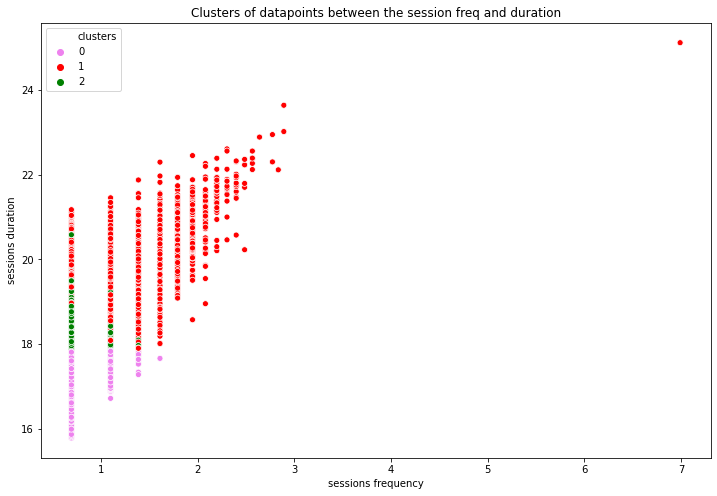

In [484]:
# comparing the clusters in variable pairs

# frequency and duration
x = norm_agg_user_data[['sessions_freq', 'sessions_duration(ms)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_freq'],  y = norm_agg_user_data['sessions_duration(ms)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])
# sns.palplot(sns.color_palette(flatui))
plt.title('Clusters of datapoints between the session freq and duration')
plt.xlabel('sessions frequency')
plt.ylabel('sessions duration')
plt.legend()

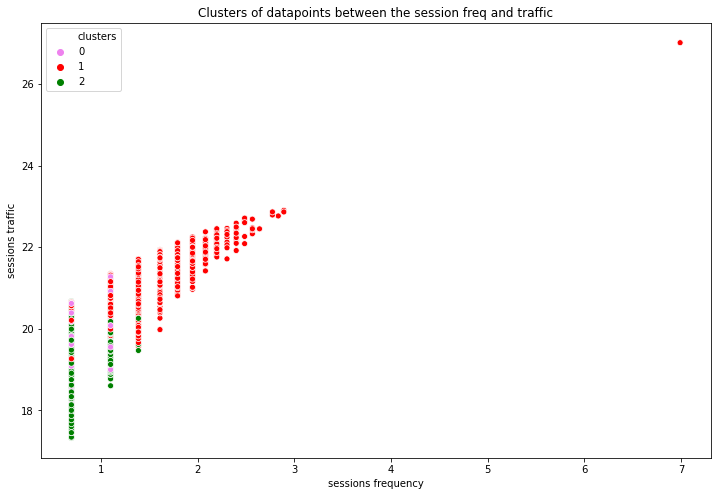

In [485]:
# comparing the clusters in variable pairs

# frequency and traffic
x = norm_agg_user_data[['sessions_freq', 'sessions_traffic(bytes)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_freq'],  y = norm_agg_user_data['sessions_traffic(bytes)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])
# sns.palplot(sns.color_palette(flatui))
plt.title('Clusters of datapoints between the session freq and traffic')
plt.xlabel('sessions frequency')
plt.ylabel('sessions traffic')
plt.legend()

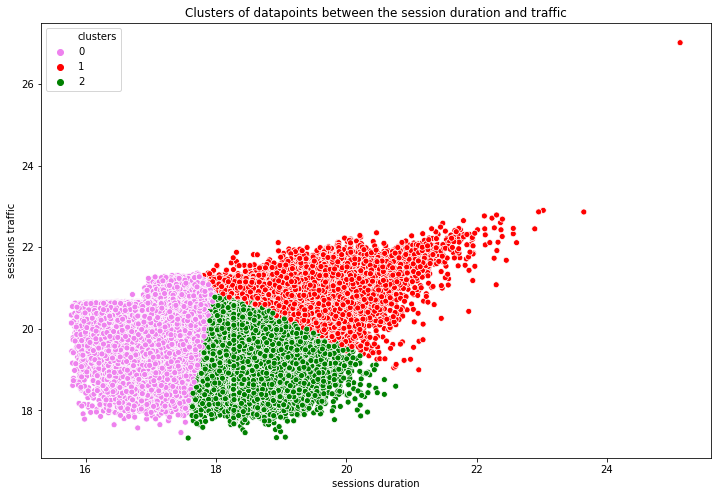

In [486]:
# comparing the clusters in variable pairs

# duration and traffic
x = norm_agg_user_data[['sessions_duration(ms)', 'sessions_traffic(bytes)', 'clusters']]
plt.figure(figsize = (12,8))
sns.scatterplot(x = norm_agg_user_data['sessions_duration(ms)'],  y = norm_agg_user_data['sessions_traffic(bytes)'], palette = ['violet', 'red', 'green'], hue = norm_agg_user_data['clusters'])
# sns.palplot(sns.color_palette(flatui))
plt.title('Clusters of datapoints between the session duration and traffic')
plt.xlabel('sessions duration')
plt.ylabel('sessions traffic')
plt.legend()

### * Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text. 

In [487]:
# add the clusters column to the non normalized data
agg_user_data['clusters'] = kmeans_data
agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,1,116720140.0,8.786906e+08,2
3.360100e+10,1,181230963.0,1.568596e+08,2
3.360100e+10,1,134969374.0,5.959665e+08,2
3.360101e+10,1,49878024.0,4.223207e+08,0
3.360101e+10,2,37104453.0,1.457411e+09,0


In [488]:
agg_user_data.clusters.value_counts()

2    54896
1    29494
0    22466
Name: clusters, dtype: int64

In [489]:
# cluster 1 (cluster = 0)
cluster_1 = agg_user_data.loc[agg_user_data['clusters'] == 0]   #get observations under cluster 1
# cluster_1.loc['total_per_metric'] = cluster_1.sum()             #get the totals per metric
print(cluster_1.shape)
cluster_1.tail()

(22466, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378988e+10,1,47989629.0,610571467.0,0
3.378991e+10,1,44199417.0,902088414.0,0
3.378992e+10,1,54339643.0,576824365.0,0
3.378994e+10,1,36812757.0,193917233.0,0
3.379000e+10,1,8810688.0,714641641.0,0


In [490]:
cluster_1.describe() # get the min, max and average per metric in cluster 1

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,22466.000000,2.246600e+04,2.246600e+04,22466.0
mean,1.109855,3.157811e+07,5.657125e+08,0.0
std,0.314985,1.329984e+07,2.959322e+08,0.0
min,1.000000,7.142988e+06,3.802236e+07,0.0
25%,1.000000,2.082711e+07,3.308632e+08,0.0
50%,1.000000,3.032519e+07,5.594369e+08,0.0
75%,1.000000,4.139189e+07,7.677527e+08,0.0
max,4.000000,6.426047e+07,1.895711e+09,0.0


In [491]:
# cluster 2 (cluster = 1)
cluster_2 = agg_user_data.loc[agg_user_data['clusters'] == 1]   #get observations under cluster 2
# cluster_2.loc['total_per_metric'] = cluster_2.sum()             #get the totals per metric
print(cluster_2.shape)
cluster_2.tail()

(29494, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378989e+10,1,173035258.0,8.529393e+08,1
3.378995e+10,2,209051329.0,1.540055e+09,1
3.378998e+10,2,210390146.0,1.094693e+09,1
3.197021e+12,1,877385325.0,2.321240e+08,1
3.370000e+14,1,253030201.0,5.962878e+08,1


In [492]:
cluster_2.describe() # get the min, max and average per metric in cluster 2

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,29494.000000,2.949400e+04,2.949400e+04,29494.0
mean,2.256289,2.887818e+08,1.223616e+09,1.0
std,6.394298,5.567422e+08,3.187913e+09,0.0
min,1.000000,5.447539e+07,1.770069e+08,1.0
25%,2.000000,1.727915e+08,8.213283e+08,1.0
50%,2.000000,2.257546e+08,1.059776e+09,1.0
75%,3.000000,3.315747e+08,1.444668e+09,1.0
max,1084.000000,8.134348e+10,5.397159e+11,1.0


In [493]:
# cluster 3 (cluster = 2)
cluster_3 = agg_user_data.loc[agg_user_data['clusters'] == 2]   #get observations under cluster 3
# cluster_3.loc['total_per_metric'] = cluster_3.sum()             #get the totals per metric
print(cluster_3.shape)
cluster_3.tail()

(54896, 4)


,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.378996e+10,1,98826284.0,645777687.0,2
3.378996e+10,1,157069852.0,710287575.0,2
3.378997e+10,1,160461578.0,208123067.0,2
3.379000e+10,1,140988659.0,480307335.0,2
8.823971e+14,1,869844200.0,139153646.0,2


In [494]:
cluster_3.describe() # get the min, max and average per metric in cluster 3

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,54896.000000,5.489600e+04,5.489600e+04,54896.0
mean,1.066016,1.177628e+08,4.657273e+08,2.0
std,0.249629,5.129752e+07,2.360029e+08,0.0
min,1.000000,4.285693e+07,3.324901e+07,2.0
25%,1.000000,8.639992e+07,2.666905e+08,2.0
50%,1.000000,9.823675e+07,4.547752e+08,2.0
75%,1.000000,1.413285e+08,6.527742e+08,2.0
max,3.000000,1.035262e+09,1.214536e+09,2.0


### * Aggregate user total traffic per application and derive the top 10 most engaged users per application 


In [495]:
apps_traffic = data[['social_media', 'netflix', 'youtube', 'google', 'email', 'gaming', 'other', 'MSISDN/Number']]
apps_traffic.tail()

,social_media,netflix,youtube,google,email,gaming,other,MSISDN/Number
149996,3.517065e+06,3.756186e+07,2.795510e+07,1.278491e+07,6.908760e+05,5.358069e+08,1.675193e+07,3.365069e+10
149997,2.352181e+06,4.064329e+07,2.216552e+07,4.415361e+06,2.121718e+06,6.316281e+08,7.146381e+08,3.366345e+10
149998,1.260239e+06,1.502970e+07,2.451641e+07,6.585469e+06,2.058277e+06,5.669338e+08,1.324156e+08,3.362189e+10
149999,8.231090e+05,1.649484e+07,1.712251e+07,7.757267e+06,2.850914e+06,3.550664e+08,8.161200e+08,3.361962e+10
150000,1.828250e+06,2.262861e+07,2.264348e+07,7.807295e+06,2.259102e+06,4.303331e+08,4.293653e+08,3.362632e+10


In [496]:
agg_apps_traffic = apps_traffic.groupby('MSISDN/Number').agg({'social_media':'sum', 'netflix':'sum', 'youtube':'sum', 'gaming':'sum', 
                                                            'google':'sum', 'email':'sum', 'other':'sum'})
agg_apps_traffic.head()

,social_media,netflix,youtube,gaming,google,email,other
MSISDN/Number,,,,,,,
3.360100e+10,2232135.0,27180981.0,21624548.0,8.124587e+08,4389005.0,1331362.0,386570872.0
3.360100e+10,2660565.0,11221763.0,12432223.0,1.197501e+08,5334863.0,3307781.0,281710071.0
3.360100e+10,3195623.0,19353900.0,21333570.0,5.388277e+08,3443126.0,3205380.0,501693672.0
3.360101e+10,280294.0,1942092.0,6977321.0,3.911261e+08,9678493.0,2284670.0,35279702.0
3.360101e+10,2912542.0,49201724.0,41533002.0,1.314798e+09,18499616.0,3305469.0,804804484.0


#### 10 users with highest social media traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest social_media traffic')

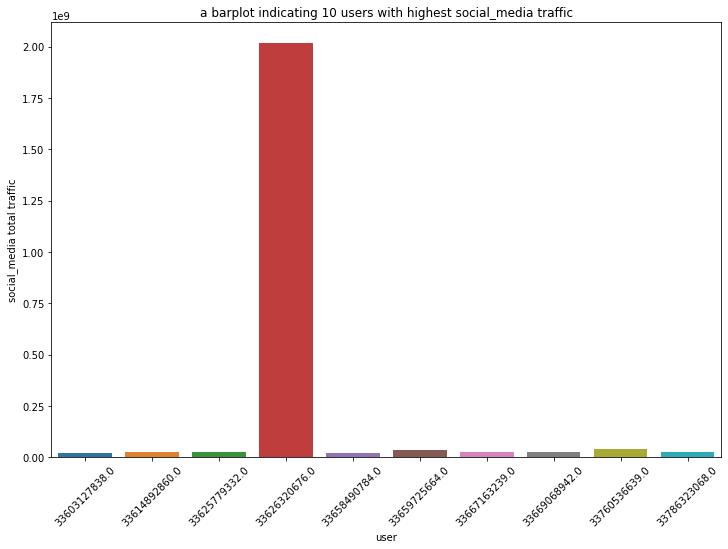

In [497]:
b = agg_apps_traffic.sort_values(by = 'social_media', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = b.index, y = b['social_media'])
plt.ylabel('social_media total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest social_media traffic')

#### 10 users with highest netflix traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest netflix traffic')

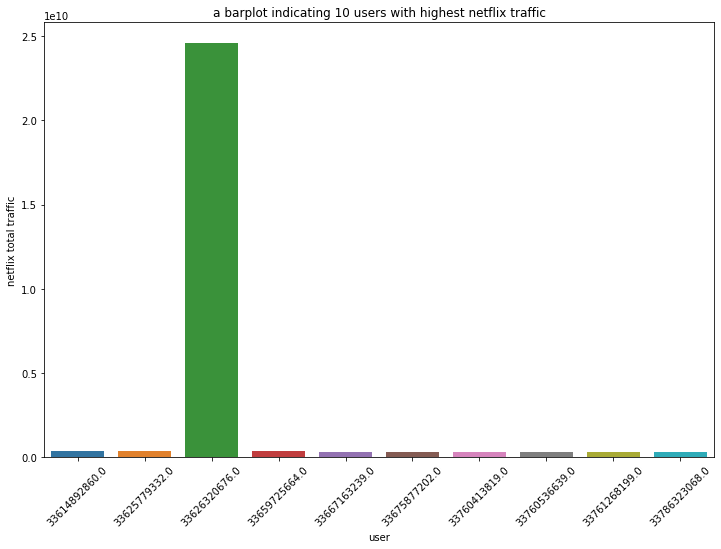

In [498]:
c = agg_apps_traffic.sort_values(by = 'netflix', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = c.index, y = c['netflix'])
plt.ylabel('netflix total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest netflix traffic')

#### 10 users with highest gaming traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest gaming traffic')

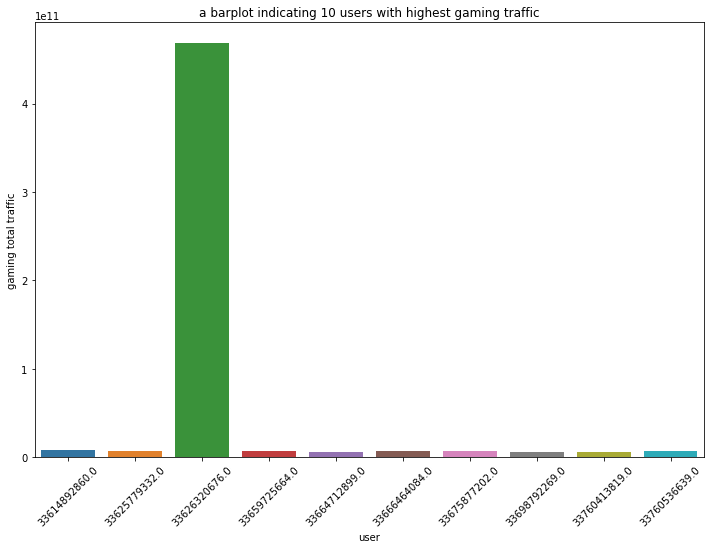

In [499]:
d = agg_apps_traffic.sort_values(by = 'gaming', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = d.index, y = d['gaming'])
plt.ylabel('gaming total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest gaming traffic')

#### 10 users with highest google traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest google traffic')

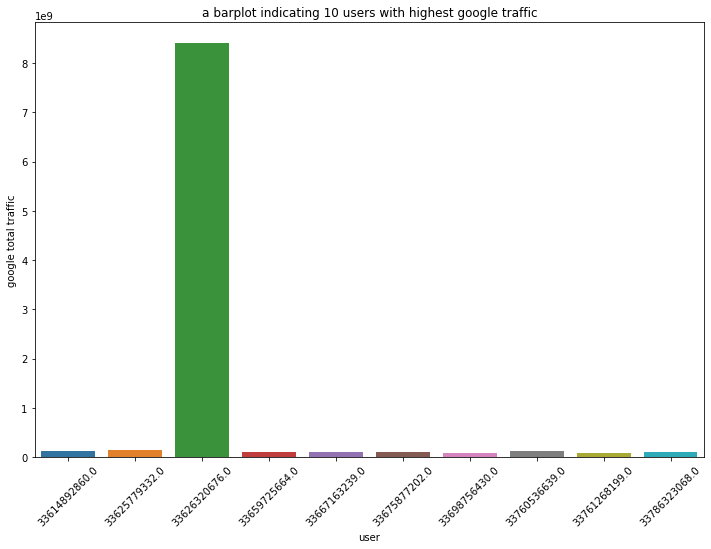

In [500]:
e = agg_apps_traffic.sort_values(by = 'google', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = e.index, y = e['google'])
plt.ylabel('google total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest google traffic')

#### 10 users with highest email traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest email traffic')

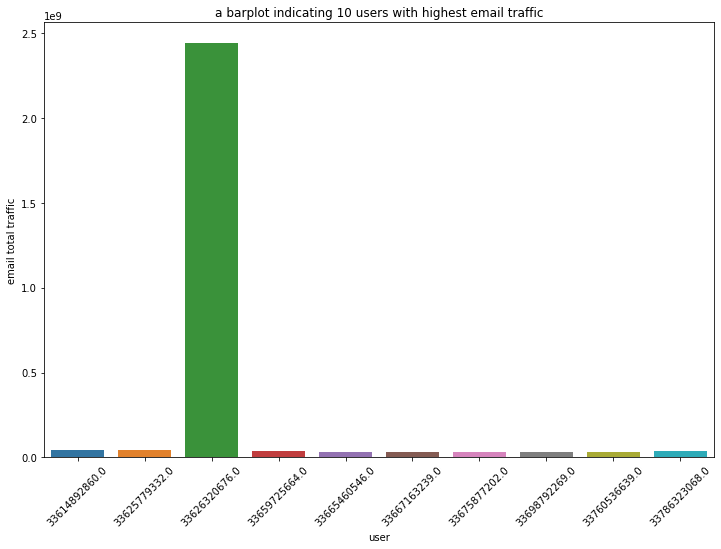

In [501]:
f = agg_apps_traffic.sort_values(by = 'email', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = f.index, y = f['email'])
plt.ylabel('email total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest email traffic')

#### 10 users with highest youtube traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest youtube traffic')

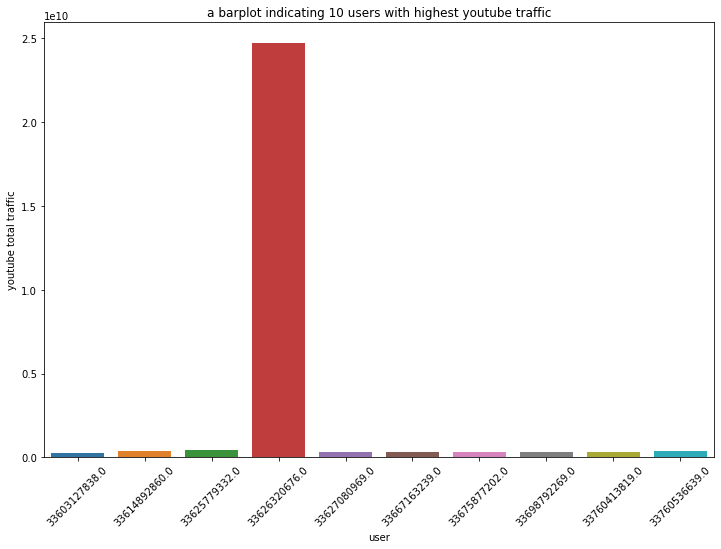

In [502]:
g = agg_apps_traffic.sort_values(by = 'youtube', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = g.index, y = g['youtube'])
plt.ylabel('youtube total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest youtube traffic')

#### 10 users with highest other traffic

Text(0.5, 1.0, 'a barplot indicating 10 users with highest other traffic')

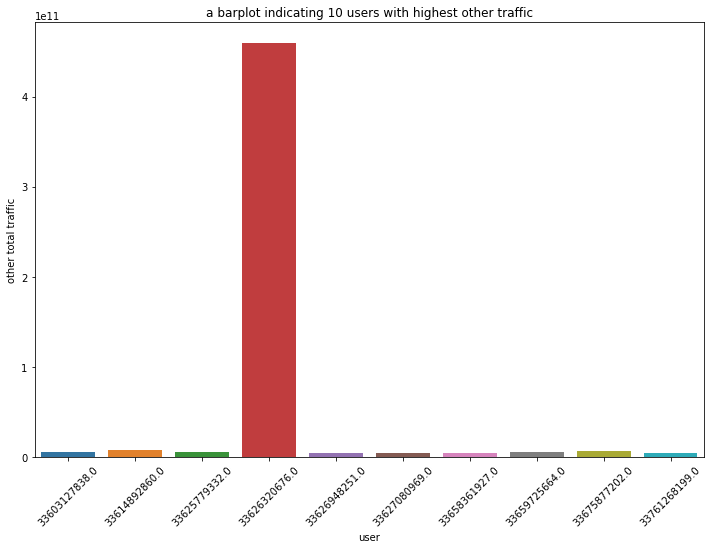

In [503]:
h = agg_apps_traffic.sort_values(by = 'other', ascending = False).head(10)
plt.figure(figsize = (12,8))
sns.barplot(x = h.index, y = h['other'])
plt.ylabel('other total traffic')
plt.xlabel('user')
plt.xticks(rotation = 45)
plt.title('a barplot indicating 10 users with highest other traffic')

In [504]:
# users in the 3 categories.
b = b.index.to_list()
c = c.index.to_list()
d = d.index.to_list()
e = e.index.to_list()
f = f.index.to_list()
g = g.index.to_list()
h = h.index.to_list()


def IntersecOfSets(arr1, arr2, arr3, arr4, arr5, arr6, arr7): 
    s1 = set(arr1) 
    s2 = set(arr2) 
    s3 = set(arr3) 
    s4 = set(arr4)
    s5 = set(arr5)
    s6 = set(arr6)
    s7 = set(arr7)

    set1 = s1.intersection(s2)
    set2 = set1.intersection(s3) 
    set3 = set2.intersection(s4)
    set4 = set3.intersection(s5) 
    set5 = set4.intersection(s6) 
    set6 = set5.intersection(s7) 
      
    final_list = list(set6) 
    print(final_list) 
  
IntersecOfSets(b, c, d, e, f, g, h) 

[33625779332.0, 33614892860.0, 33626320676.0]


### * Plot the top 3 most used applications.
Most used applications can be determined by the Application with highest traffic data or the application with the most users.


In [505]:
agg_apps_traffic.loc['total_app_traffic'] = agg_apps_traffic.sum()  
agg_apps_traffic.tail()

,social_media,netflix,youtube,gaming,google,email,other
MSISDN/Number,,,,,,,
33789997247.0,4.985690e+05,8.531060e+06,1.985157e+07,4.370033e+08,5.429705e+06,2.514097e+06,2.111151e+08
3197020876596.0,7.152240e+05,2.659230e+07,1.195990e+07,1.780487e+08,1.043866e+07,1.520771e+06,4.705265e+08
337000037000919.0,5.215660e+05,3.090504e+07,3.673494e+07,5.101427e+08,9.830617e+06,3.318582e+06,1.491884e+08
882397108489451.0,1.546088e+06,2.884623e+07,4.094071e+07,4.307026e+07,9.218647e+06,3.330974e+06,4.013605e+08
total_app_traffic,2.742394e+11,3.394314e+12,3.396545e+12,6.455040e+13,1.171102e+12,3.388676e+11,6.440523e+13


Text(0.5, 0, 'application')

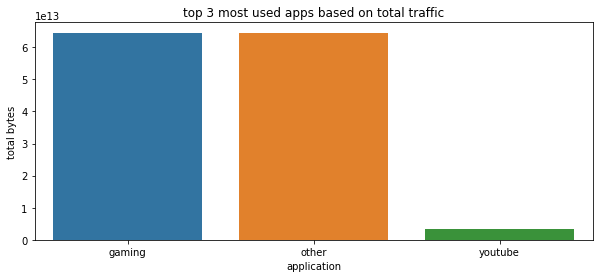

In [506]:
a = agg_apps_traffic.tail(1)
long_df = pd.melt(a)
long_df = long_df.sort_values(by = 'value', ascending = False).head(3)
plt.figure(figsize=(10,4))
sns.barplot(x = long_df.variable, y = long_df.value)
plt.title('top 3 most used apps based on total traffic')
plt.ylabel('total bytes')
plt.xlabel('application')

### * Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 


In [507]:
# the user engagement metrics df (already normalized due to different units of measurement)
norm_agg_user_data = norm_agg_user_data.drop(['clusters'], axis = 1)
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes)
MSISDN/Number,,,
3.360100e+10,0.693147,18.575290,20.593943
3.360100e+10,0.693147,19.015283,18.870862
3.360100e+10,0.693147,18.720558,20.205695
3.360101e+10,0.693147,17.725091,19.861276
3.360101e+10,1.098612,17.429248,21.099927


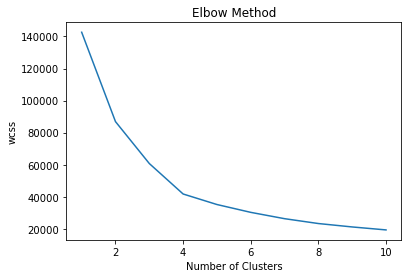

In [508]:
# determining number of clusters using elbow plot
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(norm_agg_user_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

**k=4**

In [668]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
kmeans.fit(norm_agg_user_data)
y_means = kmeans.predict(norm_agg_user_data)
agg_user_data['clusters'] = y_means
# agg_user_data = agg_user_data.drop(['clusetrs'], axis = 1)
agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,1,116720140.0,8.786906e+08,3
3.360100e+10,1,181230963.0,1.568596e+08,0
3.360100e+10,1,134969374.0,5.959665e+08,3
3.360101e+10,1,49878024.0,4.223207e+08,1
3.360101e+10,2,37104453.0,1.457411e+09,1


In [670]:
#clusters df
cluster_1 = agg_user_data[agg_user_data.clusters == 0]
cluster_2 = agg_user_data[agg_user_data.clusters == 1]
cluster_3 = agg_user_data[agg_user_data.clusters == 2]
cluster_4 = agg_user_data[agg_user_data.clusters == 3]

In [671]:
# descriptions
cluster_1.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,18091.000000,1.809100e+04,1.809100e+04,18091.0
mean,1.042728,1.440717e+08,2.118416e+08,0.0
std,0.203883,7.005880e+07,9.371678e+07,0.0
min,1.000000,3.837164e+07,3.324901e+07,0.0
25%,1.000000,8.640005e+07,1.362536e+08,0.0
50%,1.000000,1.318739e+08,2.013179e+08,0.0
75%,1.000000,1.730870e+08,2.704233e+08,0.0
max,3.000000,1.035262e+09,5.210467e+08,0.0


In [672]:
cluster_2.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,22464.000000,2.246400e+04,2.246400e+04,22464.0
mean,1.109865,3.157738e+07,5.657590e+08,1.0
std,0.314997,1.330020e+07,2.959043e+08,0.0
min,1.000000,7.142988e+06,4.259776e+07,1.0
25%,1.000000,2.082655e+07,3.309482e+08,1.0
50%,1.000000,3.032120e+07,5.595104e+08,1.0
75%,1.000000,4.139283e+07,7.677583e+08,1.0
max,4.000000,6.426047e+07,1.895711e+09,1.0


In [673]:
cluster_3.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,28521.000000,2.852100e+04,2.852100e+04,28521.0
mean,2.266576,2.956454e+08,1.225861e+09,2.0
std,6.502002,5.648880e+08,3.241558e+09,0.0
min,1.000000,5.822995e+07,1.770069e+08,2.0
25%,2.000000,1.727999e+08,8.161924e+08,2.0
50%,2.000000,2.316329e+08,1.053662e+09,2.0
75%,3.000000,3.366571e+08,1.454053e+09,2.0
max,1084.000000,8.134348e+10,5.397159e+11,2.0


In [675]:
cluster_4.describe()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
count,37780.000000,3.778000e+04,3.778000e+04,37780.0
mean,1.100053,1.043836e+08,6.051028e+08,3.0
std,0.302709,3.153317e+07,2.000766e+08,0.0
min,1.000000,5.095930e+07,2.116345e+08,3.0
25%,1.000000,8.639982e+07,4.529820e+08,3.0
50%,1.000000,9.065647e+07,5.896928e+08,3.0
75%,1.000000,1.224708e+08,7.422662e+08,3.0
max,3.000000,2.422936e+08,1.787052e+09,3.0


## 3. Experience Analytics

Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable) -(jupyter notebook):
Average TCP retransmission
Average RTT
Handset type
Average throughput


In [511]:
# data[numerical].columns

In [512]:
net_data = data[['MSISDN/Number', 'Handset Type', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
                'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]

net_data.head()

,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.000000,5.000000,23.0,44.0,2.080991e+07,759658.664811
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.000000,5.000000,16.0,26.0,2.080991e+07,759658.664811
2,3.376063e+10,Samsung Galaxy A8 (2018),109.795706,17.662883,6.0,9.0,2.080991e+07,759658.664811
3,3.375034e+10,undefined,109.795706,17.662883,44.0,44.0,2.080991e+07,759658.664811
4,3.369980e+10,Samsung Sm-G390F,109.795706,17.662883,6.0,9.0,2.080991e+07,759658.664811


In [513]:
# null values are already treated, let's check the outliers using IQR score

#check if the exist
# RTT DL
Q1 = np.percentile(net_data['Avg RTT DL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT DL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT DL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT DL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT DL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT DL (ms)'] > (Q3 + 1.5 * IQR))
m = o.unique()

#RTT UL
Q1 = np.percentile(net_data['Avg RTT UL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT UL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT UL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT UL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT UL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT UL (ms)'] > (Q3 + 1.5 * IQR))
n = o.unique()

#TP DL
Q1 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP DL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP DL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP DL (kbps)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TP UL
Q1 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP UL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP UL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP UL (kbps)'] > (Q3 + 1.5 * IQR))
p = o.unique()

#TCP UL
Q1 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP UL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP UL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP UL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TCP DL
Q1 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP DL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP DL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP DL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
r = o.unique()

print('rtt dl', m)
print('rtt ul', n)
print('tp ul', p)
print('tp dl', q)
print('tcp dl', r)
print('tcp ul', q)

rtt dl [False  True]
rtt ul [False  True]
tp ul [False  True]
tp dl [False  True]
tcp dl [False  True]
tcp ul [False  True]


In [514]:
# o.shape
# net_data.shape

They all have outliers, now we have to treat them by replacing them with the low and high percentiles.


In [515]:
net_data['Avg RTT DL (ms)'] = net_data['Avg RTT DL (ms)'].clip(lower=net_data['Avg RTT DL (ms)'].quantile(0.07), upper=net_data['Avg RTT DL (ms)'].quantile(0.93))
net_data['Avg RTT UL (ms)'] = net_data['Avg RTT UL (ms)'].clip(lower=net_data['Avg RTT UL (ms)'].quantile(0.10), upper=net_data['Avg RTT UL (ms)'].quantile(0.90))
net_data['Avg Bearer TP DL (kbps)'] = net_data['Avg Bearer TP DL (kbps)'].clip(lower=net_data['Avg Bearer TP DL (kbps)'].quantile(0.05), upper=net_data['Avg Bearer TP DL (kbps)'].quantile(0.95))
net_data['Avg Bearer TP UL (kbps)'] = net_data['Avg Bearer TP UL (kbps)'].clip(lower=net_data['Avg Bearer TP UL (kbps)'].quantile(0.20), upper=net_data['Avg Bearer TP UL (kbps)'].quantile(0.80))
net_data['TCP UL Retrans. Vol (Bytes)'] = net_data['TCP UL Retrans. Vol (Bytes)'].clip(lower=net_data['TCP UL Retrans. Vol (Bytes)'].quantile(0.05), upper=net_data['TCP UL Retrans. Vol (Bytes)'].quantile(0.95))
net_data['TCP DL Retrans. Vol (Bytes)'] = net_data['TCP DL Retrans. Vol (Bytes)'].clip(lower=net_data['TCP DL Retrans. Vol (Bytes)'].quantile(0.05), upper=net_data['TCP DL Retrans. Vol (Bytes)'].quantile(0.95))

In [516]:
# Confirming they've been treated
# RTT DL
Q1 = np.percentile(net_data['Avg RTT DL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT DL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT DL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT DL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT DL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT DL (ms)'] > (Q3 + 1.5 * IQR))
m = o.unique()

#RTT UL
Q1 = np.percentile(net_data['Avg RTT UL (ms)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg RTT UL (ms)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg RTT UL (ms)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg RTT UL (ms)'], interpolation = 'midpoint') 
o = (net_data['Avg RTT UL (ms)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg RTT UL (ms)'] > (Q3 + 1.5 * IQR))
n = o.unique()

#TP DL
Q1 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP DL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP DL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP DL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP DL (kbps)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TP UL
Q1 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['Avg Bearer TP UL (kbps)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['Avg Bearer TP UL (kbps)'], interpolation = 'midpoint') 
o = (net_data['Avg Bearer TP UL (kbps)'] < (Q1 - 1.5 * IQR)) |(net_data['Avg Bearer TP UL (kbps)'] > (Q3 + 1.5 * IQR))
p = np.unique(o, return_counts = True)

#TCP UL
Q1 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP UL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP UL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP UL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP UL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
q = o.unique()

#TCP DL
Q1 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 25, interpolation = 'midpoint')  
Q2 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 50, interpolation = 'midpoint')  
Q3 = np.percentile(net_data['TCP DL Retrans. Vol (Bytes)'], 75, interpolation = 'midpoint')  
IQR = stats.iqr(net_data['TCP DL Retrans. Vol (Bytes)'], interpolation = 'midpoint') 
o = (net_data['TCP DL Retrans. Vol (Bytes)'] < (Q1 - 1.5 * IQR)) |(net_data['TCP DL Retrans. Vol (Bytes)'] > (Q3 + 1.5 * IQR))
r = o.unique()

print('rtt dl', m)
print('rtt ul', n)
print('tp ul', p)
print('tp dl', q)
print('tcp dl', r)
print('tcp ul', q)

rtt dl [False]
rtt ul [False]
tp ul (array([False]), array([150001]))
tp dl [False]
tcp dl [False]
tcp ul [False]


All good now.

In [ ]:
# # replacing with mean
# mean = float(net_data['Avg Bearer TP UL (kbps)'].mean())
# lower=net_data['Avg Bearer TP UL (kbps)'].quantile(0.10)
# upper=net_data['Avg Bearer TP UL (kbps)'].quantile(0.90)
# net_data['Avg Bearer TP UL (kbps)'] = np.where((net_data['Avg Bearer TP UL (kbps)']  > upper), mean, net_data['Avg Bearer TP UL (kbps)'])
# net_data['Avg Bearer TP UL (kbps)'] = np.where((net_data['Avg Bearer TP UL (kbps)']  < lower), mean, net_data['Avg Bearer TP UL (kbps)'])

In [517]:
# generate total columns for rtt, tp and tcp
net_data['total_tp(kbps)'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
net_data['total_rtt(ms)'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
net_data['total_tcp(bytes)'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']
net_data.head()

,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,42.000000,5.000000,23.0,45.0,2.080991e+07,759658.664811,67.0,47.000000,2.156957e+07
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),65.000000,5.000000,16.0,45.0,2.080991e+07,759658.664811,42.0,70.000000,2.156957e+07
2,3.376063e+10,Samsung Galaxy A8 (2018),109.795706,17.662883,11.0,45.0,2.080991e+07,759658.664811,15.0,127.458589,2.156957e+07
3,3.375034e+10,undefined,109.795706,17.662883,44.0,45.0,2.080991e+07,759658.664811,88.0,127.458589,2.156957e+07
4,3.369980e+10,Samsung Sm-G390F,109.795706,17.662883,11.0,45.0,2.080991e+07,759658.664811,15.0,127.458589,2.156957e+07


In [518]:
# aggregating

# handset type
a = net_data[['MSISDN/Number', 'Handset Type']]
b = a.groupby('MSISDN/Number').count()
print(b.shape)
b = b.reset_index()
b.head()

(106856, 1)


,MSISDN/Number,Handset Type
0,3.360100e+10,1
1,3.360100e+10,1
2,3.360100e+10,1
3,3.360101e+10,1
4,3.360101e+10,2


In [519]:
# the others
c = net_data.drop(['Handset Type'], axis = 1)
d = c.groupby('MSISDN/Number').sum()
d = d.reset_index()
print(d.shape)
d.head()

(106856, 10)


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.360100e+10,46.000000,1.000000,37.0,45.0,2.080991e+07,759658.664811,76.0,46.000000,2.156957e+07
1,3.360100e+10,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811,99.0,31.000000,2.156957e+07
2,3.360100e+10,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811,97.0,127.458589,2.156957e+07
3,3.360101e+10,69.000000,15.000000,204.0,45.0,4.316000e+03,759658.664811,248.0,84.000000,7.607247e+05
4,3.360101e+10,114.000000,6.000000,40395.0,1673.0,3.015954e+07,780860.664811,56844.0,119.000000,3.094040e+07


In [520]:
# Merging them
agg_net_data = pd.merge(left=b, right=d, how='left', left_on='MSISDN/Number', right_on='MSISDN/Number')
print(agg_net_data.shape)
agg_net_data.head()

(106856, 11)


,MSISDN/Number,Handset Type,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.360100e+10,1,46.000000,1.000000,37.0,45.0,2.080991e+07,759658.664811,76.0,46.000000,2.156957e+07
1,3.360100e+10,1,30.000000,1.000000,48.0,51.0,2.080991e+07,759658.664811,99.0,31.000000,2.156957e+07
2,3.360100e+10,1,109.795706,17.662883,48.0,49.0,2.080991e+07,759658.664811,97.0,127.458589,2.156957e+07
3,3.360101e+10,1,69.000000,15.000000,204.0,45.0,4.316000e+03,759658.664811,248.0,84.000000,7.607247e+05
4,3.360101e+10,2,114.000000,6.000000,40395.0,1673.0,3.015954e+07,780860.664811,56844.0,119.000000,3.094040e+07


### Compute & list 10 of the top, bottom and most frequent:
* TCP values in the dataset. 
* RTT values in the dataset.
* Throughput values in the dataset.


In [647]:
#tcp
tcp = data.sort_values(by = 'total_tcp', ascending = False)
top_tcp = tcp.total_tcp.head(10)
bottom_tcp = tcp.total_tcp.tail(10)
fre_tcp = data.total_tcp.value_counts(ascending = False).head(10)
print('top tcp\n', top_tcp.to_list())
print('bottom tcp\n', bottom_tcp.to_list())
print('freq tcp\n', fre_tcp.index.to_list())

top tcp
 [4344115651.0, 4301477439.0, 4294431965.0, 4291464950.0, 4288120860.0, 4275491713.0, 4268647350.0, 4261616039.0, 4260174145.0, 4254659643.0]
bottom tcp
 [143.0, 134.0, 134.0, 129.0, 128.0, 113.0, 108.0, 106.0, 97.0, 86.0]
freq tcp
 [21569572.935152996, 20811208.27034193, 760988.6648110661, 20811244.27034193, 759696.6648110661, 20811232.27034193, 759750.6648110661, 762318.6648110661, 760976.6648110661, 20812574.27034193]


In [648]:
#rtt
rtt = data.sort_values(by = 'total_rtt', ascending = False)
top_rtt= rtt.total_rtt.head(10)
bottom_rtt = rtt.total_rtt.tail(10)
fre_rtt = data.total_rtt.value_counts(ascending = False).head(10)
print('top rtt\n', top_rtt.to_list())
print('bottom rtt\n', bottom_rtt.to_list())
print('freq rtt\n', fre_rtt.index.to_list())

top rtt
 [96924.0, 64641.0, 55812.0, 54848.0, 27278.0, 26300.0, 25922.0, 25715.0, 25388.0, 24738.0]
bottom rtt
 [6.0, 6.0, 5.0, 4.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0]
freq rtt
 [127.45858896466059, 29.0, 39.0, 38.0, 40.0, 30.0, 28.0, 49.0, 41.0, 31.0]


In [646]:
tp = data.sort_values(by = 'total_tp', ascending = False)
top_tp = tp.total_tp.head(10)
bottom_tp = tp.total_tp.tail(10)
fre_tp = data.total_tp.value_counts(ascending = False).head(10)
print('top tp\n', top_tp.to_list())
print('bottom tp\n', bottom_tp.to_list())
print('freq tp\n', fre_tp.index.to_list())

top tp
 [382262.0, 313244.0, 304299.0, 300546.0, 283931.0, 281144.0, 277152.0, 276205.0, 274052.0, 269888.0]
bottom tp
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
freq tp
 [63.0, 15.0, 97.0, 90.0, 98.0, 96.0, 99.0, 89.0, 91.0, 93.0]


In [521]:
# user-based plots on the same

# tcp
a = agg_net_data.sort_values(by = 'total_tcp(bytes)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_tcp(bytes)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_tcp(bytes)'].value_counts(ascending = False).head(10))

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Top 10 TCP values')]

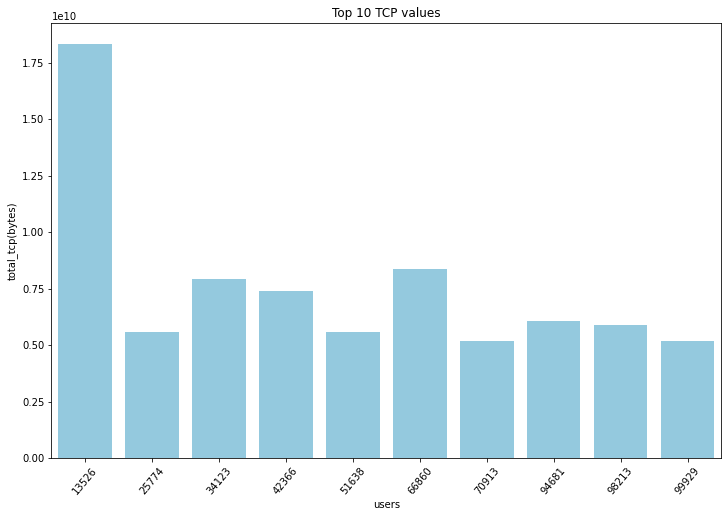

In [522]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_tcp(bytes)'], color="skyblue").set(title = 'Top 10 TCP values', xlabel = 'users')

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Bottom 10 TCP values')]

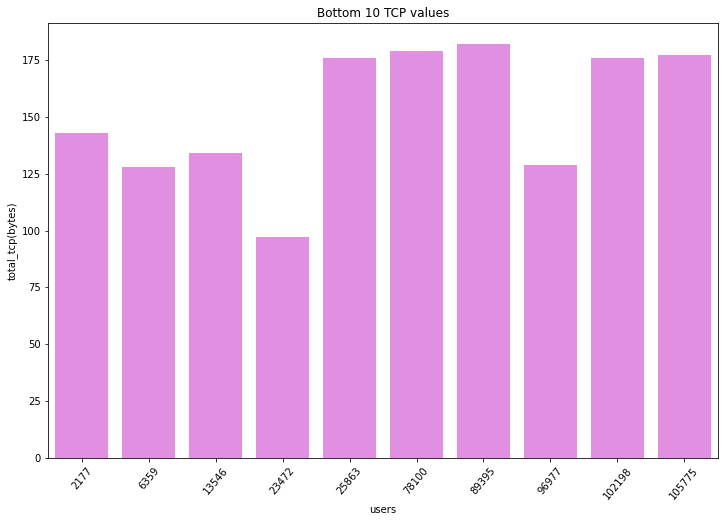

In [523]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_tcp(bytes)'], color="violet").set(title = 'Bottom 10 TCP values', xlabel = 'users')

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Frequent 10 TCP values')]

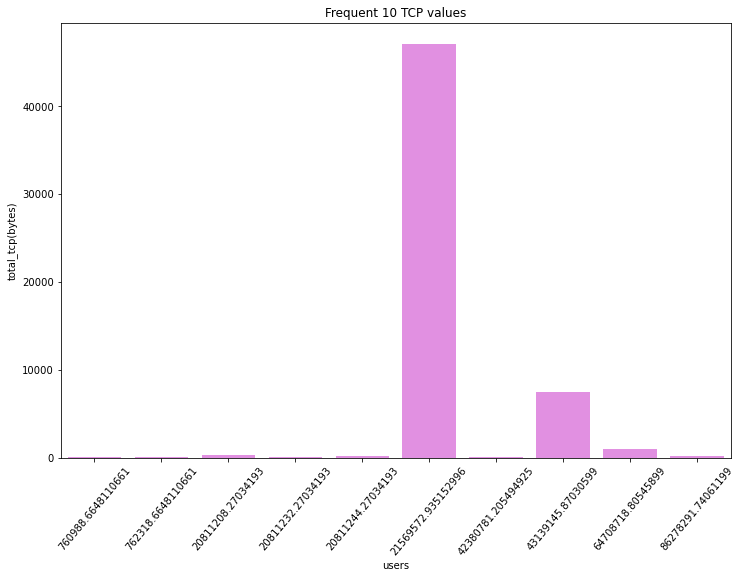

In [524]:
# Frequent 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = c.index ,y = c['total_tcp(bytes)'], color="violet").set(title = 'Frequent 10 TCP values', xlabel = 'users')

In [525]:
# rtt
a = agg_net_data.sort_values(by = 'total_rtt(ms)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_rtt(ms)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_rtt(ms)'].value_counts(ascending = False).head(10))

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Top 10 rtt values')]

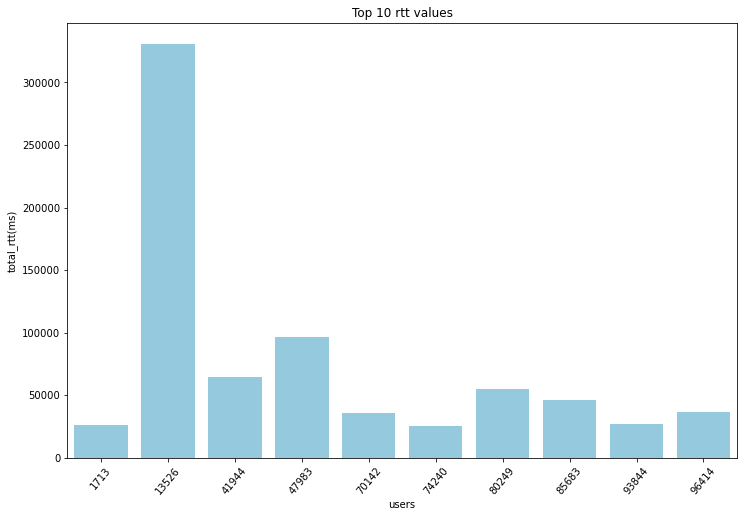

In [526]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_rtt(ms)'], color="skyblue").set(title = 'Top 10 rtt values', xlabel = 'users')

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Bottom 10 rtt values')]

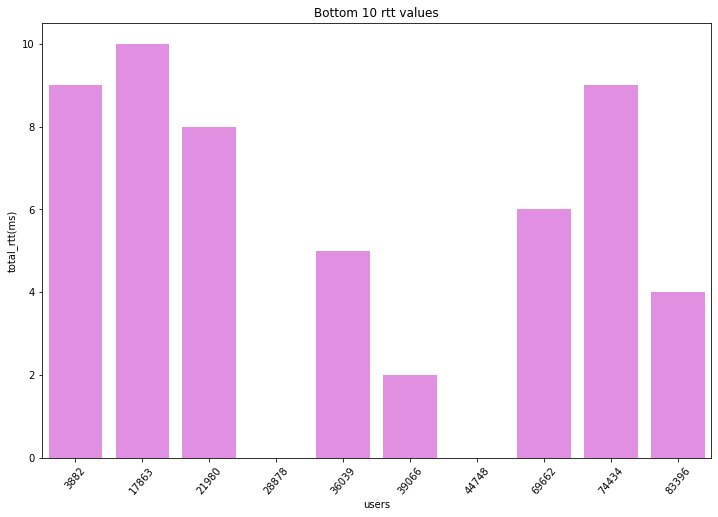

In [527]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_rtt(ms)'], color="violet").set(title = 'Bottom 10 rtt values', xlabel = 'users')

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Frequent 10 rtt values')]

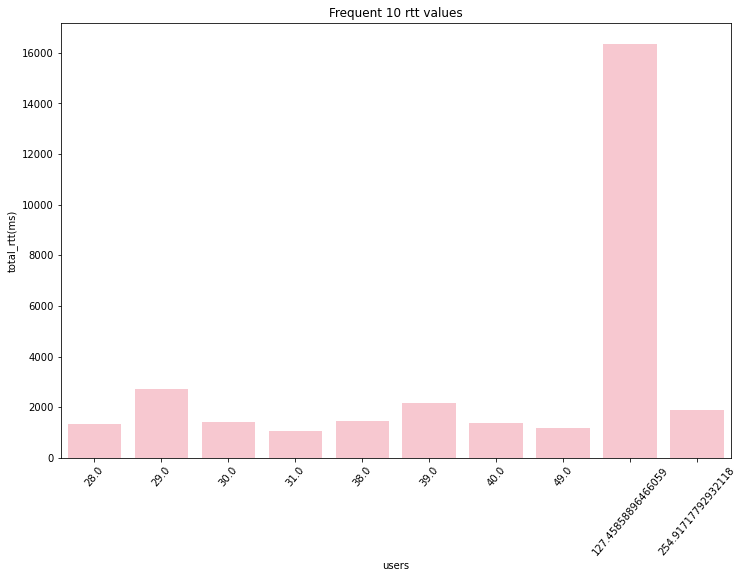

In [528]:
# Frequent 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = c.index ,y = c['total_rtt(ms)'], color="pink").set(title = 'Frequent 10 rtt values', xlabel = 'users')

In [529]:
# tp
a = agg_net_data.sort_values(by = 'total_tp(kbps)', ascending = False).head(10)
b = agg_net_data.sort_values(by = 'total_tp(kbps)', ascending = False).tail(10)
c = pd.DataFrame(agg_net_data['total_tp(kbps)'].value_counts(ascending = False).head(10))

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Top 10 tp values')]

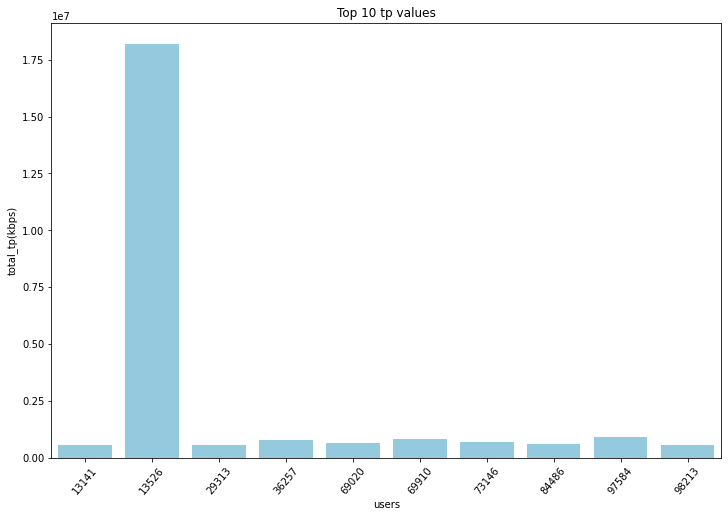

In [530]:
# top 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['total_tp(kbps)'], color="skyblue").set(title = 'Top 10 tp values', xlabel = 'users')

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Bottom 10 tp values')]

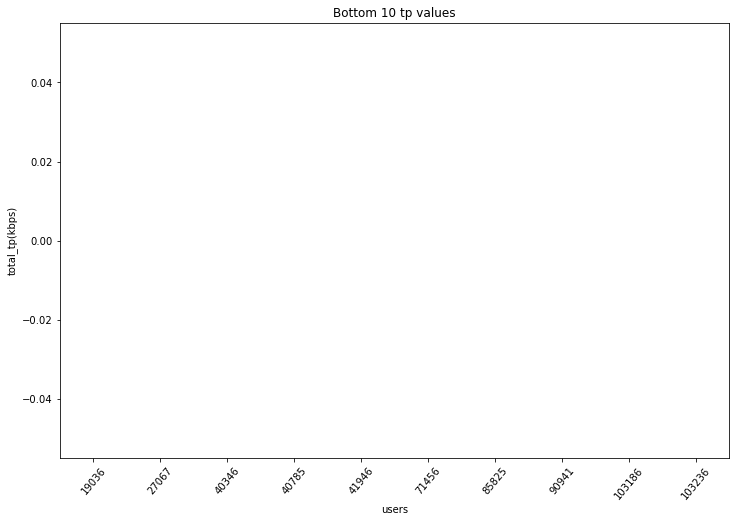

In [531]:
# bottom 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['total_tp(kbps)'], color="violet").set(title = 'Bottom 10 tp values', xlabel = 'users')

all zeros.

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Frequent 10 tp values')]

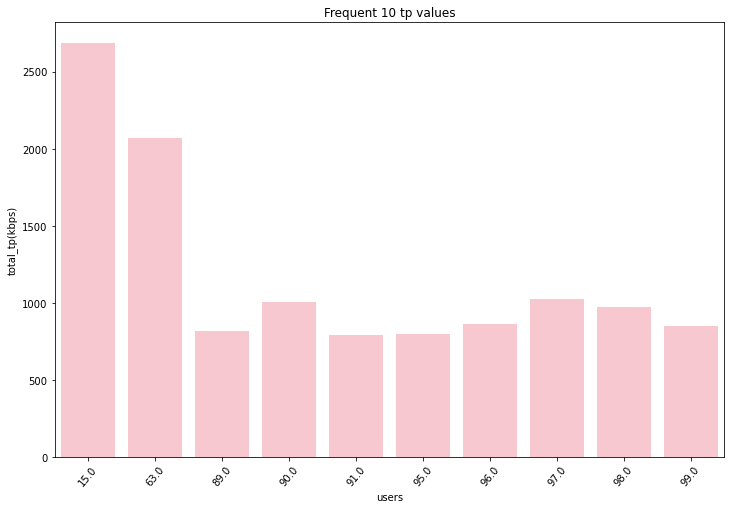

In [532]:
# Frequent 10
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = c.index ,y = c['total_tp(kbps)'], color="pink").set(title = 'Frequent 10 tp values', xlabel = 'users')

### Compute & report:
* The distribution of the average throughput  per handset type and provide interpretation for your findings.
* The average TCP retransmission view per handset type and provide interpretation for your findings.

In [533]:
data['total_tp(kbps)'] = data['Avg Bearer TP DL (kbps)'] + data['Avg Bearer TP UL (kbps)']
data['total_rtt(ms)'] = data['Avg RTT DL (ms)'] + data['Avg RTT UL (ms)']
data['total_tcp(bytes)'] = data['TCP DL Retrans. Vol (Bytes)'] + data['TCP UL Retrans. Vol (Bytes)']

handset_data = data[['Handset Type', 'total_tp(kbps)', 'total_tcp(bytes)']]
agg_handset_data = handset_data.groupby('Handset Type').mean()
agg_handset_data.columns = ['avg_tp_per_set', 'avg_tcp_per_set']
agg_handset_data.head()

,avg_tp_per_set,avg_tcp_per_set
Handset Type,,
A-Link Telecom I. Cubot A5,23510.0,2.156957e+07
A-Link Telecom I. Cubot Note Plus,6699.0,6.162130e+05
A-Link Telecom I. Cubot Note S,8937.0,4.141173e+07
A-Link Telecom I. Cubot Nova,56217.0,1.371700e+05
A-Link Telecom I. Cubot Power,69468.0,8.041000e+03



 mu = 12400.38 and sigma = 14661.81



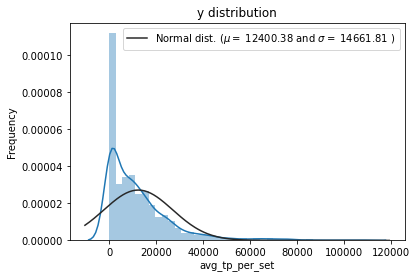

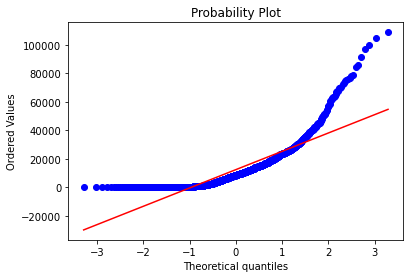

In [534]:
# Average throughput/handset ~ distribution
sns.distplot(agg_handset_data['avg_tp_per_set'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(agg_handset_data['avg_tp_per_set'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(agg_handset_data['avg_tp_per_set'], plot=plt)
plt.show()

Heavily right tailed - Highly skewed.

[Text(0.5, 0, 'handset type'),
 Text(0.5, 1.0, 'Top 10 handsets types per average tcp value')]

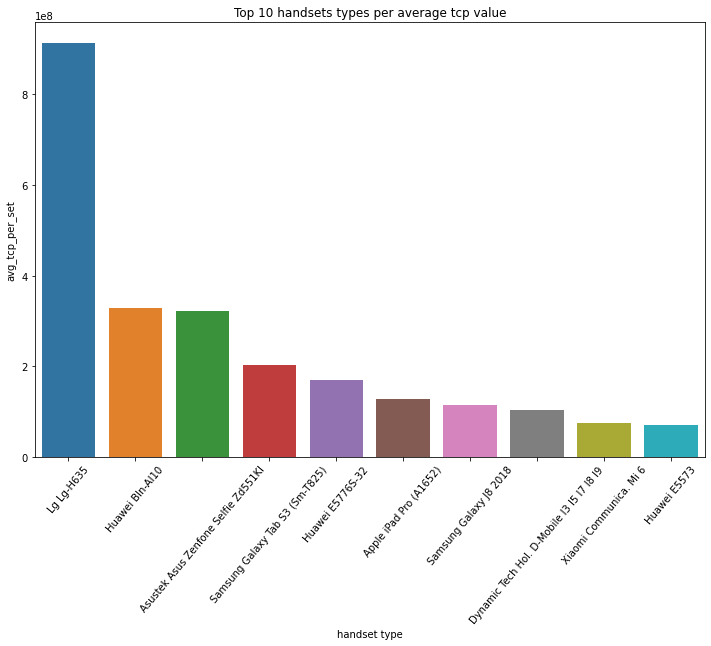

In [535]:
# The average TCP retransmission view per handset type and provide interpretation for your findings.
# aggregate function has already been applied 

# top 10 handsets per tcp average
a = agg_handset_data.sort_values(by = 'avg_tcp_per_set', ascending = False).head(10)

plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['avg_tcp_per_set']).set(title = 'Top 10 handsets types per average tcp value', xlabel = 'handset type')

6 of the handset types with highest average tcp values are from the top 3 handset manufacturers.

[Text(0.5, 0, 'handset type'),
 Text(0.5, 1.0, 'Bottom 10 handsets types per average tcp value')]

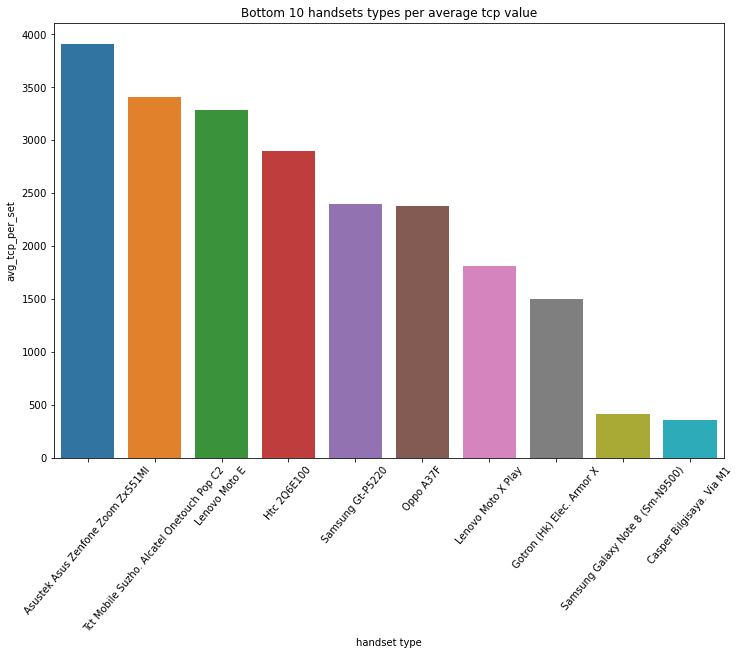

In [536]:
# bottom 10 handsets per tcp average
b = agg_handset_data.sort_values(by = 'avg_tcp_per_set', ascending = False).tail(10)

plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = b.index ,y = b['avg_tcp_per_set']).set(title = 'Bottom 10 handsets types per average tcp value', xlabel = 'handset type')

### Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster.

In [659]:
cluster_data = agg_net_data[['Handset Type', 'total_tp(kbps)', 'total_rtt(ms)',  'total_tcp(bytes)']]
norm_cluster_data = np.log1p(cluster_data)   #log transformation
norm_cluster_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,0.693147,4.343805,3.850148,16.886794
1,0.693147,4.605170,3.465736,16.886794
2,0.693147,4.584967,4.855607,16.886794
3,0.693147,5.517453,4.442651,13.542028
4,1.098612,10.948084,4.787492,17.247574


In [661]:
# kmeans on 3 clusters.
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(norm_cluster_data)
kmeans_data = kmeans.predict(norm_cluster_data)

In [662]:
# add the predicted clusters as a column in the df
cluster_data['clusters'] = pd.Series(kmeans_data, index=cluster_data.index)
cluster_data['clusters'] = pd.Series(kmeans_data, index=cluster_data.index)
cluster_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
0,1,76.0,46.000000,2.156957e+07,0
1,1,99.0,31.000000,2.156957e+07,0
2,1,97.0,127.458589,2.156957e+07,0
3,1,248.0,84.000000,7.607247e+05,0
4,2,56844.0,119.000000,3.094040e+07,1


In [663]:
#clusters df
cluster_1 = cluster_data[cluster_data.clusters == 0]
cluster_2 = cluster_data[cluster_data.clusters == 1]
cluster_3 = cluster_data[cluster_data.clusters == 2]

In [664]:
# understand the clusters
cluster_1.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,57867.000000,57867.000000,57867.000000,5.786700e+04,57867.0
mean,1.199181,161.199008,121.934653,2.522595e+07,0.0
std,0.500237,238.588215,721.290566,1.163534e+07,0.0
min,1.000000,0.000000,0.000000,2.398920e+05,0.0
25%,1.000000,77.000000,38.000000,2.156957e+07,0.0
50%,1.000000,99.000000,69.000000,2.156957e+07,0.0
75%,1.000000,132.000000,127.458589,2.156957e+07,0.0
max,9.000000,2340.000000,96924.000000,5.395976e+08,0.0


In [665]:
cluster_2.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,28955.000000,2.895500e+04,28955.000000,2.895500e+04,28955.0
mean,2.057261,6.014344e+04,266.025148,6.094625e+07,1.0
std,6.459691,1.228969e+05,2009.173348,3.106838e+08,0.0
min,1.000000,1.157000e+03,17.000000,1.183841e+06,1.0
25%,1.000000,1.969850e+04,88.000000,1.075893e+07,1.0
50%,2.000000,4.285900e+04,149.000000,2.187841e+07,1.0
75%,2.000000,7.664150e+04,261.000000,3.487863e+07,1.0
max,1084.000000,1.819958e+07,330840.833436,1.834177e+10,1.0


In [666]:
cluster_3.describe()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),clusters
count,20034.000000,20034.000000,20034.000000,2.003400e+04,20034.0
mean,1.050215,25446.984976,217.638269,5.495192e+05,2.0
std,0.246524,27972.299457,702.770868,5.058399e+05,0.0
min,1.000000,38.000000,19.000000,9.700000e+01,2.0
25%,1.000000,4772.500000,49.000000,7.403175e+04,2.0
50%,1.000000,16964.000000,72.000000,4.899780e+05,2.0
75%,1.000000,36836.750000,154.000000,7.914237e+05,2.0
max,5.000000,382871.000000,27278.000000,3.340765e+06,2.0


## 4. Satisfaction Analysis

### Write a python program to assign:
* engagement score to each user. Consider the engagement score as the Euclidean distance between the user data point & the less engaged cluster (use the first clustering for this).

In [565]:
# the results of the 1st clustering
norm_agg_user_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),clusters
MSISDN/Number,,,,
3.360100e+10,0.693147,18.575290,20.593943,2
3.360100e+10,0.693147,19.015283,18.870862,2
3.360100e+10,0.693147,18.720558,20.205695,2
3.360101e+10,0.693147,17.725091,19.861276,0
3.360101e+10,1.098612,17.429248,21.099927,0


In [566]:
norm_agg_user_data.shape

(106856, 4)

In [567]:
# Identifying the least engaged cluster
norm_agg_user_data.clusters.value_counts()

2    54896
1    29494
0    22466
Name: clusters, dtype: int64

Cluster 0 is the less engaged cluster, with the lowest count of 19362 data points.
* **engagement_score = euclidean_dist between a datapoint and cluster's 2 centroid.**

In [568]:
data1 = norm_agg_user_data.drop(['clusters'], axis = 1)

km = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
alldistances = km.fit_transform(data1) #returns euclidean distance btwn all datapoints and each cluster centroid

dist_df = pd.DataFrame(alldistances)
dist_2 = dist_df.iloc[:, 0].to_list() #pick out the centroid 2 distances
print(len(dist_2))
dist_2[:10]

106856


[1.538824560112309,
 2.1577596701082573,
 1.5725320585152427,
 0.5742908931111399,
 1.2061470824847222,
 2.232413745924267,
 1.5808898950585217,
 1.1665279517393703,
 2.9712637866710794,
 1.5401914570024002]

In [ ]:
# add the distances as engagement score column

In [569]:
norm_agg_user_data['engagement_score'] = dist_2
eng_scores_data = norm_agg_user_data.drop(['clusters'], axis = 1)
eng_scores_data.head()

,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),engagement_score
MSISDN/Number,,,,
3.360100e+10,0.693147,18.575290,20.593943,1.538825
3.360100e+10,0.693147,19.015283,18.870862,2.157760
3.360100e+10,0.693147,18.720558,20.205695,1.572532
3.360101e+10,0.693147,17.725091,19.861276,0.574291
3.360101e+10,1.098612,17.429248,21.099927,1.206147


* experience score to each user. Consider the experience score as the Euclidean distance between the user data point & the worst experience’s cluster.

In [570]:
# picking out the 4 cols
exp_data = net_data.drop(['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 
                          'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)'], axis = 1)
exp_data.head()

,MSISDN/Number,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes)
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,67.0,47.000000,2.156957e+07
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),42.0,70.000000,2.156957e+07
2,3.376063e+10,Samsung Galaxy A8 (2018),15.0,127.458589,2.156957e+07
3,3.375034e+10,undefined,88.0,127.458589,2.156957e+07
4,3.369980e+10,Samsung Sm-G390F,15.0,127.458589,2.156957e+07


In [571]:
# groupby user
agg_exp_data = exp_data.groupby('MSISDN/Number').agg({'Handset Type':'count', 'total_tp(kbps)':'sum', 'total_rtt(ms)':'sum', 'total_tcp(bytes)':'sum'})
agg_exp_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes)
MSISDN/Number,,,,
3.360100e+10,1,76.0,46.000000,2.156957e+07
3.360100e+10,1,99.0,31.000000,2.156957e+07
3.360100e+10,1,97.0,127.458589,2.156957e+07
3.360101e+10,1,248.0,84.000000,7.607247e+05
3.360101e+10,2,56844.0,119.000000,3.094040e+07


In [572]:
# normalize and perform kmeans
norm_agg_exp_data = np.log1p(agg_exp_data)
norm_agg_exp_data.head()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes)
MSISDN/Number,,,,
3.360100e+10,0.693147,4.343805,3.850148,16.886794
3.360100e+10,0.693147,4.605170,3.465736,16.886794
3.360100e+10,0.693147,4.584967,4.855607,16.886794
3.360101e+10,0.693147,5.517453,4.442651,13.542028
3.360101e+10,1.098612,10.948084,4.787492,17.247574


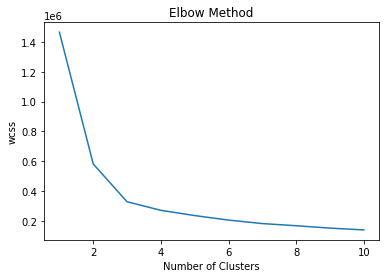

In [573]:
# determining number of clusters using elbow plot
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(norm_agg_exp_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

k = 3

In [574]:
# fit kmeans and identify least engaged cluster
k_means = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
k_means.fit(norm_agg_exp_data)
clusters=k_means.predict(norm_agg_exp_data)

norm_agg_exp_data['clusters'] = clusters
norm_agg_exp_data.clusters.value_counts()

0    57867
1    28955
2    20034
Name: clusters, dtype: int64

cluster 2 has the least.
*** exp_score = euclidean distance between datapoints and cluster 1's centroid**

In [575]:
# fit kmeans
data1 = norm_agg_exp_data.drop(['clusters'], axis = 1)

km = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
alldistances = km.fit_transform(data1) #returns euclidean distance btwn all datapoints to each cluster centroid

dist_df = pd.DataFrame(alldistances)
dist_0 = dist_df.iloc[:, 2].to_list() #pick out the centroid 0 distances
print(len(dist_0))
dist_0[:10]

106856


[6.8155240810730655,
 6.679449509194429,
 6.605156664956339,
 4.025451186161848,
 5.196907754880385,
 4.652450591422306,
 4.806292915733313,
 2.60767472033551,
 6.749975253777498,
 6.302704511465112]

In [576]:
# add the scores to the df
norm_agg_exp_data['experience_score'] = dist_0
exp_scores_data = norm_agg_exp_data.drop(['clusters'], axis = 1)
exp_scores_data.tail()

,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),experience_score
MSISDN/Number,,,,,
3.379000e+10,0.693147,9.246286,3.970292,12.292461,0.624350
3.379000e+10,0.693147,4.762174,3.713572,16.886794,6.531177
3.197021e+12,0.693147,0.693147,4.855607,16.886794,9.791285
3.370000e+14,0.693147,3.526361,4.855607,16.886794,7.405327
8.823971e+14,0.693147,1.098612,4.855607,16.886794,9.434669


In [577]:
print(exp_scores_data.shape)
print(eng_scores_data.shape)

(106856, 5)
(106856, 4)


### Merge the engagement and experience datasets

In [578]:
exp_scores_data = exp_scores_data.reset_index()
eng_scores_data = eng_scores_data.reset_index()
avg_score_df = pd.merge(left = exp_scores_data, right = eng_scores_data, left_on = 'MSISDN/Number', right_on = 'MSISDN/Number')
print(avg_score_df.shape)
avg_score_df.tail()

(106856, 10)


,MSISDN/Number,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),experience_score,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),engagement_score
106851,3.379000e+10,0.693147,9.246286,3.970292,12.292461,0.624350,0.693147,15.991476,20.387292,1.242904
106852,3.379000e+10,0.693147,4.762174,3.713572,16.886794,6.531177,0.693147,18.764190,19.989937,1.599897
106853,3.197021e+12,0.693147,0.693147,4.855607,16.886794,9.791285,0.693147,20.592457,19.262782,3.502040
106854,3.370000e+14,0.693147,3.526361,4.855607,16.886794,7.405327,0.693147,19.349019,20.206234,2.196217
106855,8.823971e+14,0.693147,1.098612,4.855607,16.886794,9.434669,0.693147,20.583825,18.751089,3.633318


In [579]:
#calculate the average score
avg_score_df['satisfaction_score'] = (avg_score_df['experience_score'] + avg_score_df['engagement_score'])/2
avg_score_df.head()

,MSISDN/Number,Handset Type,total_tp(kbps),total_rtt(ms),total_tcp(bytes),experience_score,sessions_freq,sessions_duration(ms),sessions_traffic(bytes),engagement_score,satisfaction_score
0,3.360100e+10,0.693147,4.343805,3.850148,16.886794,6.815524,0.693147,18.575290,20.593943,1.538825,4.177174
1,3.360100e+10,0.693147,4.605170,3.465736,16.886794,6.679450,0.693147,19.015283,18.870862,2.157760,4.418605
2,3.360100e+10,0.693147,4.584967,4.855607,16.886794,6.605157,0.693147,18.720558,20.205695,1.572532,4.088844
3,3.360101e+10,0.693147,5.517453,4.442651,13.542028,4.025451,0.693147,17.725091,19.861276,0.574291,2.299871
4,3.360101e+10,1.098612,10.948084,4.787492,17.247574,5.196908,1.098612,17.429248,21.099927,1.206147,3.201527


### Top 10 most satisfied users

[Text(0.5, 0, 'users'), Text(0.5, 1.0, 'Top 10 Most satisfied users')]

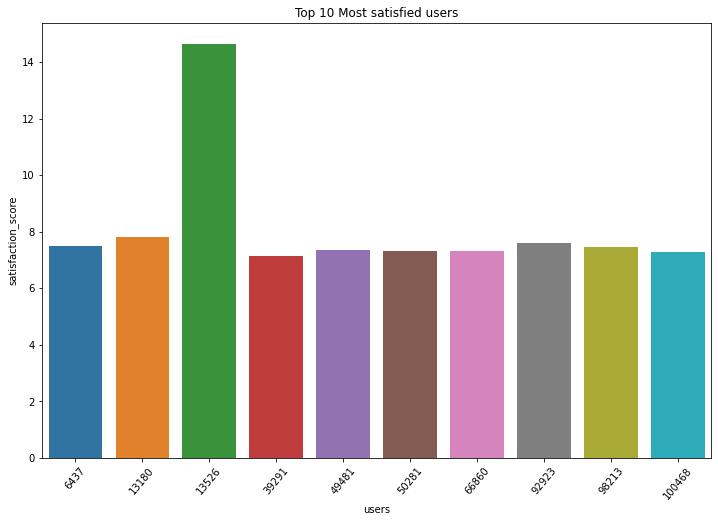

In [580]:
a = avg_score_df.sort_values(by = 'satisfaction_score', ascending = False).head(10)
plt.figure(figsize = (12,8))
plt.xticks(rotation = 50)
sns.barplot(x = a.index ,y = a['satisfaction_score']).set(title = 'Top 10 Most satisfied users', xlabel = 'users')

### Run a regression model of your choice to predict the satisfaction score of a customer. 
Working with the 4 features from the average_score df

In [583]:
all_variables = avg_score_df[['MSISDN/Number','engagement_score', 'experience_score', 'satisfaction_score']]
all_variables.head()

,MSISDN/Number,engagement_score,experience_score,satisfaction_score
0,3.360100e+10,1.538825,6.815524,4.177174
1,3.360100e+10,2.157760,6.679450,4.418605
2,3.360100e+10,1.572532,6.605157,4.088844
3,3.360101e+10,0.574291,4.025451,2.299871
4,3.360101e+10,1.206147,5.196908,3.201527


In [ ]:
# # features transformations
# def logs(res, ls):
#     m = res.shape[1]
#     for l in ls:
#         res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
#         res.columns.values[m] = l + '_log'
#         m += 1
#     return res

# log_features = ['Handset Type', 'total_tp(kbps)', 'total_rtt(ms)','total_tcp(bytes)', 'experience_score', 'sessions_freq',
#                 'sessions_duration(ms)', 'sessions_traffic(bytes)', 'engagement_score','satisfaction_score']

# all_variables = logs(avg_score_df, log_features)
# all_variables.head(2)

In [ ]:
# def squares(res, ls):
#     m = res.shape[1]
#     for l in ls:
#         res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
#         res.columns.values[m] = l + '_sq'
#         m += 1
#     return res 

# squared_features = ['Handset Type', 'total_tp(kbps)', 'total_rtt(ms)','total_tcp(bytes)', 'experience_score', 'sessions_freq',
#                     'sessions_duration(ms)', 'sessions_traffic(bytes)', 'engagement_score','satisfaction_score']

# all_variables = squares(all_variables, squared_features)
# print(all_variables.shape)
# all_variables.head(2)

In [584]:
# split  dataset into train and test sets
from sklearn.model_selection import train_test_split

x = all_variables.drop(['satisfaction_score'], axis = 1)
y = all_variables[['satisfaction_score']]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .3, random_state = 0)
print('xtrain shape:', x_train.shape)
print('xtest shape:', x_test.shape)
print('ytrain shape:', y_train.shape)
print('ytest shape:', y_test.shape)

xtrain shape: (74799, 3)
xtest shape: (32057, 3)
ytrain shape: (74799, 1)
ytest shape: (32057, 1)


In [585]:
# drop the user column from the xtrain. Save it in another df from the xtest set
x_train = x_train.drop(['MSISDN/Number'], axis = 1)
test_user = x_test[['MSISDN/Number']]
x_test = x_test.drop(['MSISDN/Number'], axis = 1)
print('xtrain shape:', x_train.shape)
print('xtest shape:', x_test.shape)
print('users df shape:', test_user.shape)

xtrain shape: (74799, 2)
xtest shape: (32057, 2)
users df shape: (32057, 1)


In [586]:
# Models hyperparameters tuning
# I intend to observe the performance of 3 models (2 boosters and one ensemble method) then use the one with the lowest MSE score to predict the x_test set.

# Random Forest
regressor = RandomForestRegressor(n_estimators=300, random_state=0)


#gradboost
gdb = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)


#xgboost
xgb = XGBRegressor(colsample_bytree=0.4603, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=0,
                             random_state =0, nthread = -1)



In [ ]:
# # fitting and observing performannce through

# # score
# n_folds = 5
# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
#     rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [ ]:
# score = rmsle_cv(xgb)
# print("\nExtreme grad boostscore: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# score = rmsle_cv(regressor)
# print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# score = rmsle_cv(gdb)
# print("\nGrad Boost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# l = [0.0012, 0.0000, 0.0037]
# c = ['xgb', 'random forest', 'gradboost']
# df = pd.DataFrame(l, index = c)
# sns.barplot(x = df.index, y = df[0])

In [587]:
# rf prediction
regressor.fit(x_train.values, y_train)
rf_pred = regressor.predict(x_test.values)

In [588]:
# xgb prediction
xgb.fit(x_train.values, y_train)
xgb_pred = xgb.predict(x_test.values)

[12:14:19] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [589]:
# gdb prediction
gdb.fit(x_train.values, y_train)
gdb_pred = gdb.predict(x_test.values)

In [591]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Mean absolute error for random forest on test data =", mean_absolute_error(y_test, rf_pred))
print("Mean absolute error for xgboost on test data=", mean_absolute_error(y_test, xgb_pred))
print("Mean absolute error for gradboost on test data=", mean_absolute_error(y_test, gdb_pred))

print("\nMean squared error for random forest on test data =", mean_squared_error(y_test, rf_pred))
print("Mean squared error for xgboost on test data=", mean_squared_error(y_test, xgb_pred))
print("Mean squared error for gradboost on test data=", mean_squared_error(y_test, gdb_pred))

Mean absolute error for random forest on test data = 0.002249444659260878
Mean absolute error for xgboost on test data= 0.004642470339612329
Mean absolute error for gradboost on test data= 0.006242991240854579

Mean squared error for random forest on test data = 4.6127912677163765e-05
Mean squared error for xgboost on test data= 0.00025893382712933083
Mean squared error for gradboost on test data= 9.160128386565683e-05


Working with the randomforest predictions since it has the smallest mean squared error.

In [592]:
# save predictions.
predictions = pd.DataFrame()
predictions['users'] = test_user['MSISDN/Number']
predictions['satisfaction_score'] = rf_pred
print(predictions.shape)
predictions.head()

(32057, 2)


,users,satisfaction_score
19972,3.364241e+10,3.712589
89091,3.369960e+10,3.780016
60375,3.366554e+10,4.398811
103157,3.377736e+10,4.875892
106784,3.378954e+10,4.326945


### Run a k-means (k=2) on the engagement & the experience score. 

In [593]:
ds = avg_score_df[['MSISDN/Number', 'engagement_score', 'experience_score']]

# no need for standardization (same unit if measurement)
k_means = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
k_means.fit(ds)
clusters=k_means.predict(ds)

ds['clusters'] = clusters
ds.tail()

,MSISDN/Number,engagement_score,experience_score,clusters
106851,3.379000e+10,1.242904,0.624350,0
106852,3.379000e+10,1.599897,6.531177,0
106853,3.197021e+12,3.502040,9.791285,0
106854,3.370000e+14,2.196217,7.405327,0
106855,8.823971e+14,3.633318,9.434669,1


### Aggregate the average engagement & experience score per cluster.

In [597]:
cluster_agg = ds.groupby('clusters').agg({'experience_score':'mean', 'engagement_score':'mean'})
cluster_agg

,experience_score,engagement_score
clusters,,
0,5.384672,1.569647
1,9.434669,3.633318


###  Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select on the exported table. 

In [602]:
!pip install mysql-connector

     |████████████████████████████████| 11.9 MB 4.7 MB/s eta 0:00:01
  Created wheel for mysql-connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247949 sha256=1463be638edb2780528d78667b931a9931ca45bd2d7f28a22bf02e91f07a067f
  Stored in directory: /root/.cache/pip/wheels/42/2f/c3/692fc7fc1f0d8c06b9175d94f0fc30f4f92348f5df5af1b8b7
Successfully built mysql-connector
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [603]:
!pip install pymysql

     |████████████████████████████████| 47 kB 1.6 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [601]:
data['MSISDN/Number'].nunique()

106856

In [599]:
df = ds[['MSISDN/Number', 'engagement_score', 'experience_score', 'satisfaction_score']]
df.to_csv('finaldf.csv')
print(df.shape)
df.head(2)

(106856, 4)


,MSISDN/Number,engagement_score,experience_score,satisfaction_score
0,3.360100e+10,1.538825,6.815524,4.177174
1,3.360100e+10,2.157760,6.679450,4.418605


In [607]:
from pandas.io import sql
import mysql.connector
import pymysql


dsn_database = "ada"  
dsn_hostname = "localhost"      
dsn_port = 3306              
dsn_uid = "user1"         
dsn_pwd = "******"      


In [676]:
con = mysql.connector.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
df.to_sql(con=con, name='final_telecomm_table', if_exists='replace', flavor='mysql')

[Back to top](#Table-of-Contents)